# Load in packages

In [106]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

import scipy
import anndata
import random
import pandas as pd
import warnings
import matplotlib.patches as mpatches
import scanpy as sc

import csv
import concurrent
import ast
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

from scipy.stats import zscore
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

import seaborn as sns

def nd(arr):
    return np.asarray(arr).reshape(-1)

# Violin plot functions

def vplot(y, ax):
    parts = ax.violinplot(
        y, showmeans=False, showmedians=False,
        showextrema=False)

    mean = y.mean()
    ax.scatter(1, mean, zorder=10, color="white")
    
    x = np.random.normal(1, 0.04, size=len(y))
    ax.scatter(x, y, color="k", s=1)
    
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    ax.set_xticks([1])
    ax.set_xticklabels([""])
    return ax

warnings.filterwarnings('ignore')

fsize=20
plt.rcParams.update({'font.size': fsize})



# Load in the "GeneFull" (i.e. exon+intron quantification) AnnData from non-species-specific-alignment (we call this the "Total" AnnData)

In [107]:
data = anndata.read_h5ad("./out_dir/workup/results/anndatas/merged/starsolo_run_1/GeneFull/adata.h5ad")

In [108]:
data # Initial matrix dimensions

AnnData object with n_obs × n_vars = 42323 × 55487
    obs: 'id', 'cell_counts', 'n_genes', 'percent_mito'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells'

In [109]:
# Which RTBCs to select for? (can omit this block if want to use all RTBCs by default
filter_for_tags = "RTBC1,RTBC2,RTBC3,RTBC4,RTBC5,RTBC6"
filter_for_tags_final = ['[' + item + ']' for item in filter_for_tags.split(',')]
if filter_for_tags.strip():
    final = []
    for tag in filter_for_tags_final:
        final.extend([x for x in list(np.array(data.obs['id'])) if tag in x])
    data = data[data.obs['id'].isin(final),:]

In [110]:
data.obs

id  cell_counts  n_genes  \
AAAAAAAAAAAAAAAA-1   [NYBot54_Stg][Odd2Bo8][RTBC1]      12415.0     4725   
AAAAAAAAAAAAAAAC-1  [NYBot77_Stg][Odd2Bo84][RTBC4]      71970.0     9591   
AAAAAAAAAAAAAAAG-1  [NYBot64_Stg][Odd2Bo70][RTBC5]      16484.0     5619   
AAAAAAAAAAAAAAAT-1  [NYBot82_Stg][Odd2Bo15][RTBC6]       2159.0     1442   
AAAAAAAAAAAAAACA-1   [NYBot3_Stg][Odd2Bo70][RTBC1]      10444.0     4383   
...                                            ...          ...      ...   
AAAAAAAAATTCCATT-3   [NYBot6_Stg][Odd2Bo62][RTBC4]          1.0        1   
AAAAAAAAATTCCCAT-3  [NYBot10_Stg][Odd2Bo48][RTBC4]          1.0        1   
AAAAAAAAATTCCCGG-3   [NYBot61_Stg][Odd2Bo7][RTBC3]          1.0        1   
AAAAAAAAATTCCCTC-3  [NYBot10_Stg][Odd2Bo64][RTBC3]          1.0        1   
AAAAAAAAATTCCGGG-3  [NYBot95_Stg][Odd2Bo87][RTBC1]          1.0        1   

                    percent_mito  
AAAAAAAAAAAAAAAA-1      4.929521  
AAAAAAAAAAAAAAAC-1      8.479922  
AAAAAAAAAAAAAAAG-1      5.423441  
AAAAAAAAAAAAAAAT-1      8.939324  
AAAAAAAAAAAAAACA-1      9.555726  
...                          ...  
AAAAAAAAATTCCATT-3      0.000000  
AAAAAAAAATTCCCAT-3      0.000000  
AAAAAAAAATTCCCGG-3      0.000000  
AAAAAAAAATTCCCTC-3      0.000000  
AAAAAAAAATTCCGGG-3      0.000000  

[39311 rows x 4 columns]

In [111]:
data.var

gene_id       gene_name  gene_counts  n_cells
4933401J01Rik   ENSMUSG00000102693   4933401J01Rik          0.0        0
Gm26206         ENSMUSG00000064842         Gm26206          0.0        0
Xkr4            ENSMUSG00000051951            Xkr4        127.0      119
Gm18956         ENSMUSG00000102851         Gm18956          0.0        0
Gm37180         ENSMUSG00000103377         Gm37180          0.0        0
...                            ...             ...          ...      ...
CAAA01205117.1  ENSMUSG00000094431  CAAA01205117.1          0.0        0
CAAA01098150.1  ENSMUSG00000094621  CAAA01098150.1          0.0        0
CAAA01064564.1  ENSMUSG00000098647  CAAA01064564.1          0.0        0
Vmn2r122        ENSMUSG00000096730        Vmn2r122          0.0        0
CAAA01147332.1  ENSMUSG00000095742  CAAA01147332.1         62.0       59

[55487 rows x 4 columns]

# Make plots

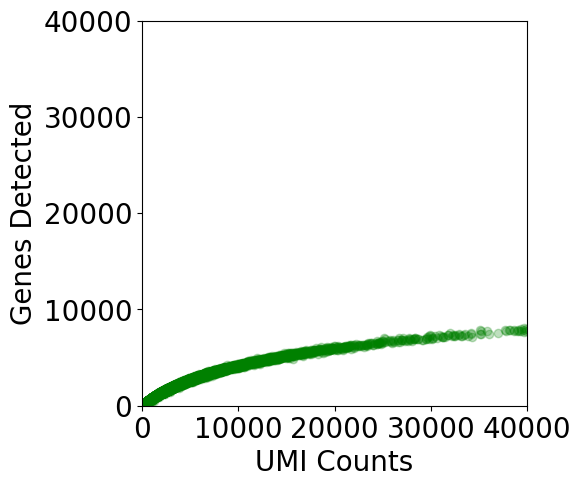

In [112]:
fig, ax = plt.subplots(figsize=(5, 5))
x = nd(data.X.sum(axis=1))
y = nd(np.sum(data.X>0, axis=1))
ax.scatter(x, y, color="green", alpha=0.25)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xlim(0,40000)
ax.set_ylim(0,40000)
ax.set_aspect('equal', adjustable='box')

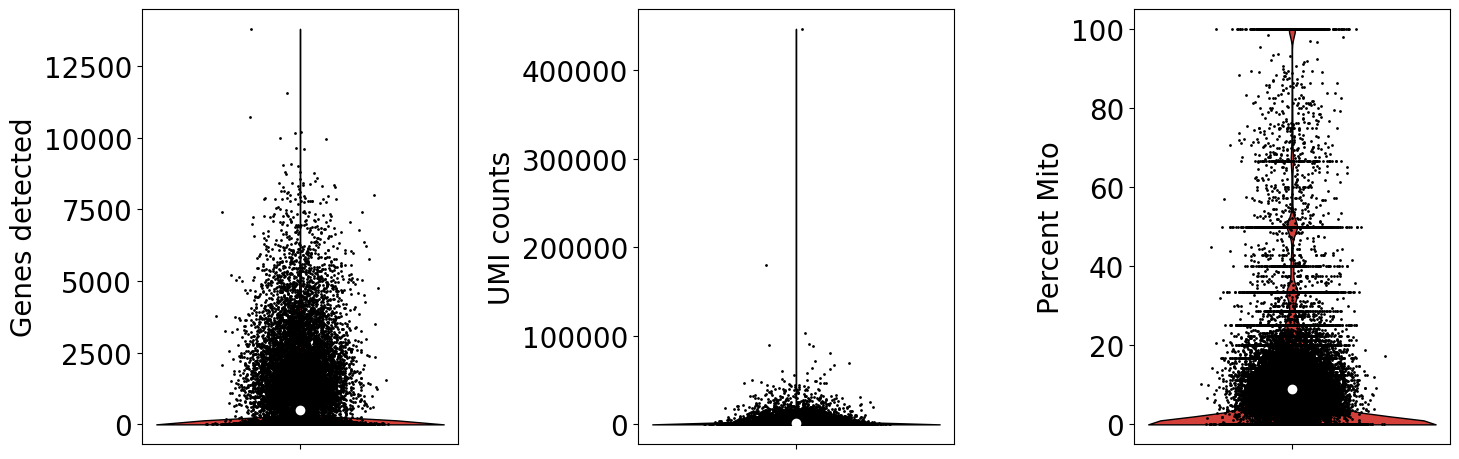

In [113]:
fig, ax = plt.subplots(figsize=(5*3,5), ncols=3)
x1 = data.obs["n_genes"]
x2 = nd(data.X.sum(axis=1))
x3 = data.obs["percent_mito"]
vplot(x1, ax[0])
vplot(x2, ax[1])
vplot(x3, ax[2])
ax[0].set_ylabel("Genes detected")
ax[1].set_ylabel("UMI counts")
ax[2].set_ylabel("Percent Mito")
plt.tight_layout()

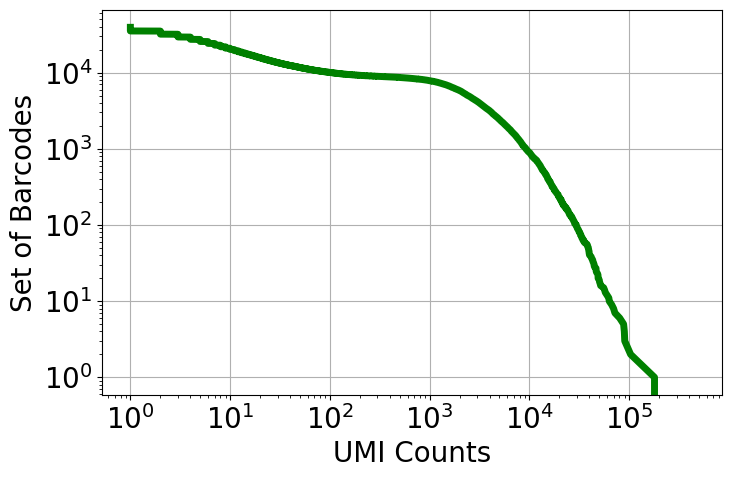

In [114]:
knee = np.sort(nd(data.X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(8, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="g")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")
ax.grid()

In [116]:
data # Print matrix dimensions (number of barcodes x number of genes)

View of AnnData object with n_obs × n_vars = 39311 × 55487
    obs: 'id', 'cell_counts', 'n_genes', 'percent_mito'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells'

# Impose filtering thresholds (and replot)

In [117]:
adata = data.copy()
umi_threshold_min = 5000
umi_threshold_max = 200000
mito_threshold = 100 # Filter by max mitochondrial content (%); 100 = no filtering
# UMI filtering:
adata.obs["pass_count_filter"] = (adata.obs["cell_counts"] >= umi_threshold_min) & (adata.obs["cell_counts"] < umi_threshold_max)
pass_count_filter = adata.obs["pass_count_filter"]
cell_mask = adata.obs["pass_count_filter"].values
adata = adata[cell_mask, :]
# Mitochondrial percentage filtering
mask = np.logical_or((adata.obs.percent_mito <= mito_threshold).values, (adata.obs.percent_mito <= mito_threshold).values)
adata = adata[mask, :]

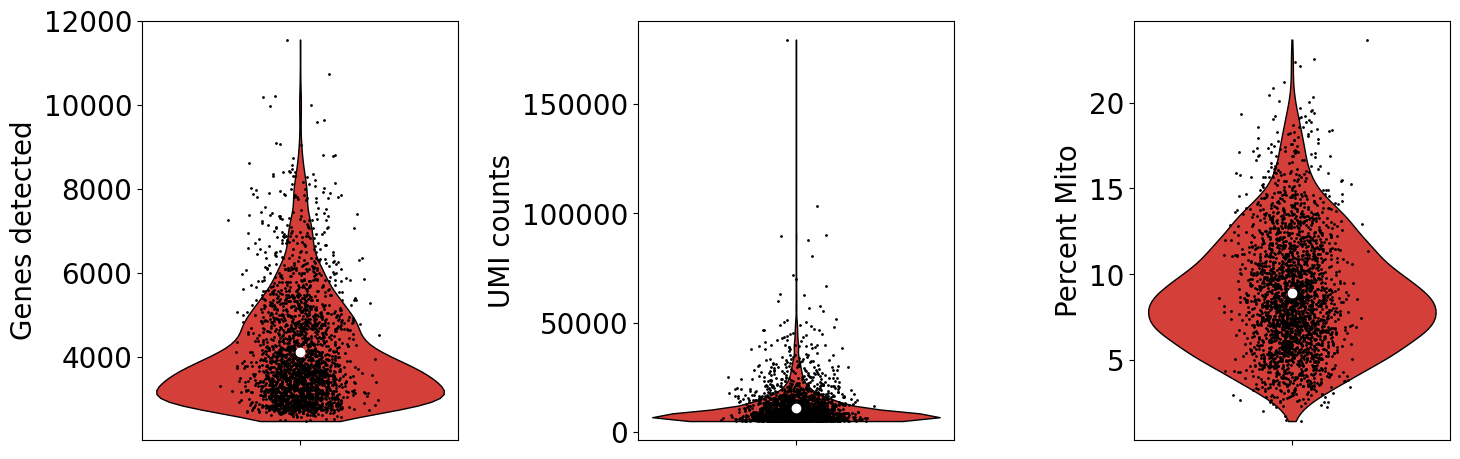

In [118]:
fig, ax = plt.subplots(figsize=(5*3,5), ncols=3)
x1 = adata.obs["n_genes"]
x2 = nd(adata.X.sum(axis=1))
x3 = adata.obs["percent_mito"]
vplot(x1, ax[0])
vplot(x2, ax[1])
vplot(x3, ax[2])
ax[0].set_ylabel("Genes detected")
ax[1].set_ylabel("UMI counts")
ax[2].set_ylabel("Percent Mito")
plt.tight_layout()

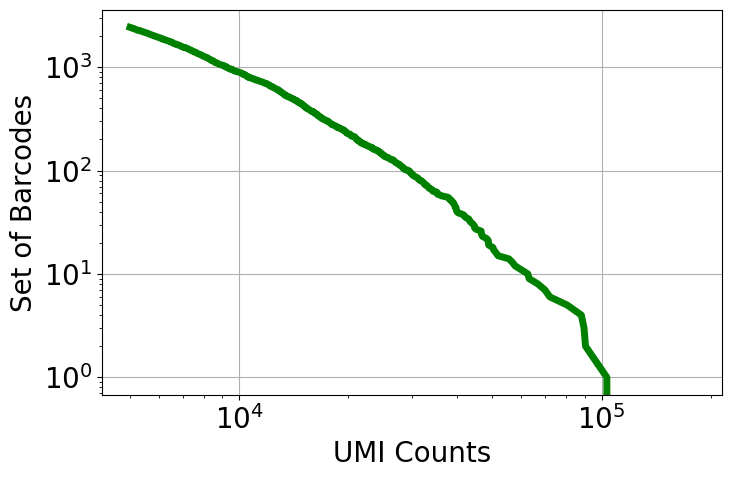

In [119]:
knee = np.sort(nd(adata.X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(8, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="g")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")
ax.grid()

In [120]:
adata # Print matrix dimensions (number of barcodes x number of genes)

View of AnnData object with n_obs × n_vars = 2428 × 55487
    obs: 'id', 'cell_counts', 'n_genes', 'percent_mito', 'pass_count_filter'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells'

# Load in allele-specific mapping GeneFull anndatas and subset them to contain same barcodes as the filtered total anndata

In [126]:
barcodes = adata.obs.index

In [127]:
data_1 = anndata.read_h5ad("./out_dir/workup/results/anndatas/merged/starsolo_run_1/CAST_EiJ/GeneFull/adata.h5ad")
data_2 = anndata.read_h5ad("./out_dir/workup/results/anndatas/merged/starsolo_run_1/129S1_SvImJ/GeneFull/adata.h5ad")
valid_barcodes = barcodes[barcodes.isin(data_1.obs.index)]
adata_1 = data_1[valid_barcodes]
valid_barcodes = barcodes[barcodes.isin(data_2.obs.index)]
adata_2 = data_2[valid_barcodes]

## Allele 1 (CAST)

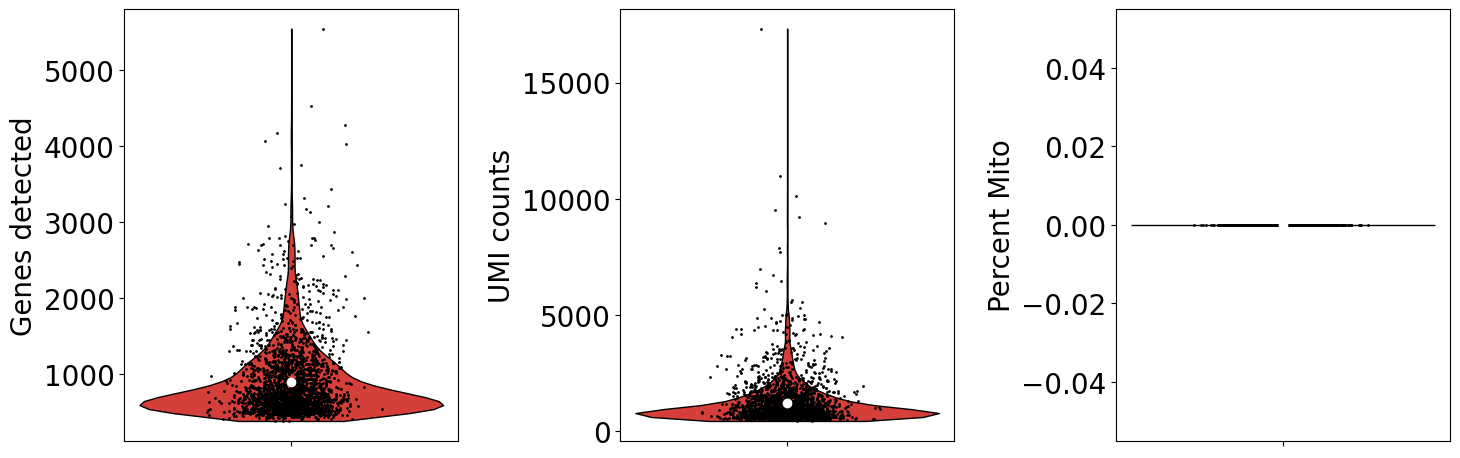

In [150]:
fig, ax = plt.subplots(figsize=(5*3,5), ncols=3)
x1 = adata_1.obs["n_genes"]
x2 = nd(adata_1.X.sum(axis=1))
x3 = adata_1.obs["percent_mito"]
vplot(x1, ax[0])
vplot(x2, ax[1])
vplot(x3, ax[2])
ax[0].set_ylabel("Genes detected")
ax[1].set_ylabel("UMI counts")
ax[2].set_ylabel("Percent Mito")
plt.tight_layout()

## Allele 2 (129)

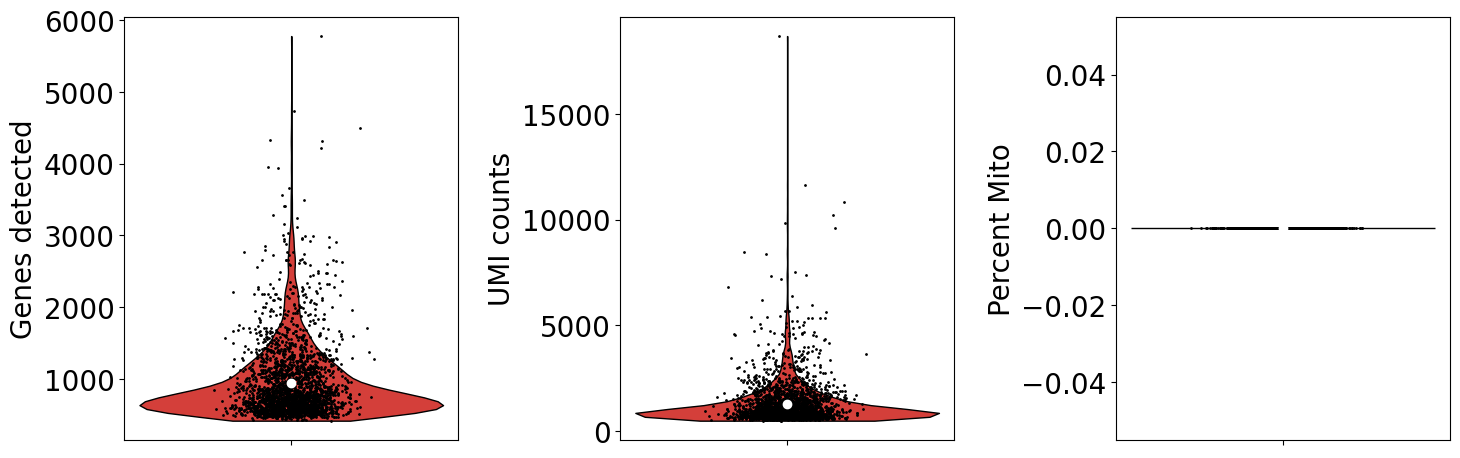

In [151]:
fig, ax = plt.subplots(figsize=(5*3,5), ncols=3)
x1 = adata_2.obs["n_genes"]
x2 = nd(adata_2.X.sum(axis=1))
x3 = adata_2.obs["percent_mito"]
vplot(x1, ax[0])
vplot(x2, ax[1])
vplot(x3, ax[2])
ax[0].set_ylabel("Genes detected")
ax[1].set_ylabel("UMI counts")
ax[2].set_ylabel("Percent Mito")
plt.tight_layout()

# Summary of the anndatas we have

In [128]:
adata # Filtered total anndata

View of AnnData object with n_obs × n_vars = 2428 × 55487
    obs: 'id', 'cell_counts', 'n_genes', 'percent_mito', 'pass_count_filter'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells'

In [129]:
adata_1 # Filtered species 1 (CAST) anndata

View of AnnData object with n_obs × n_vars = 2428 × 55487
    obs: 'id', 'cell_counts', 'n_genes', 'percent_mito'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells'

In [130]:
adata_2 # Filtered species 2 (129) anndata

View of AnnData object with n_obs × n_vars = 2428 × 55487
    obs: 'id', 'cell_counts', 'n_genes', 'percent_mito'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells'

# Plot Xist-related genes for individual RTBCs

## RTBC1-only

### Total

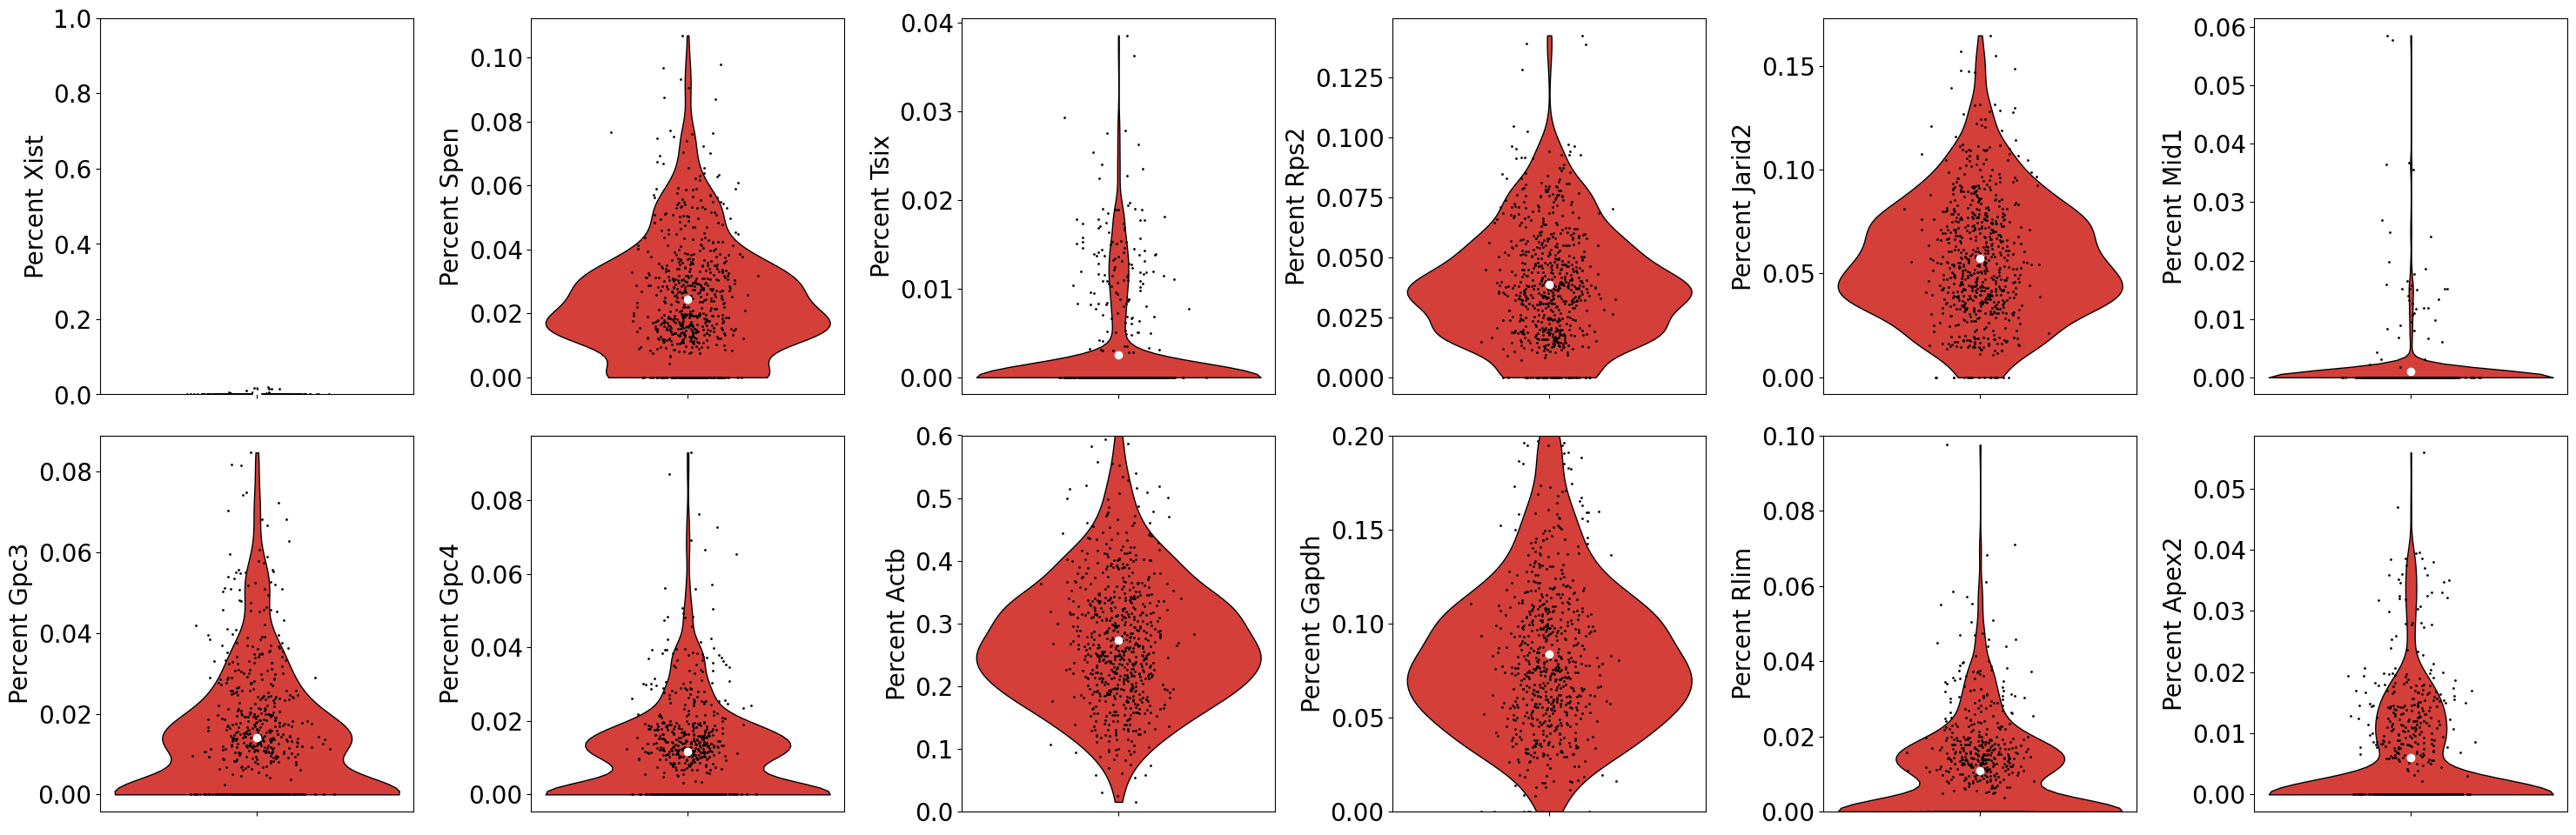

In [131]:
filtered_data = adata[adata.obs['id'].str.endswith('[RTBC1]')].copy()
adata_ = filtered_data.copy()

# List of genes

gene1 = 'Xist'
gene2 = 'Spen'
gene3 = 'Tsix'
gene4 = 'Rps2'
gene5 = 'Jarid2'
gene6 = 'Mid1'
gene7 = 'Gpc3'
gene8 = 'Gpc4'
gene9 = 'Actb'
gene10 = 'Gapdh'
gene11 = 'Rlim'
gene12 = 'Apex2'

fig, ax = plt.subplots(figsize=(5*6,5*2), ncols=6, nrows=1*2)
x1 = np.squeeze(np.asarray((adata_[:,gene1].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x2 = np.squeeze(np.asarray((adata_[:,gene2].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x3 = np.squeeze(np.asarray((adata_[:,gene3].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x4 = np.squeeze(np.asarray((adata_[:,gene4].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x5 = np.squeeze(np.asarray((adata_[:,gene5].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x6 = np.squeeze(np.asarray((adata_[:,gene6].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x7 = np.squeeze(np.asarray((adata_[:,gene7].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x8 = np.squeeze(np.asarray((adata_[:,gene8].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x9 = np.squeeze(np.asarray((adata_[:,gene9].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x10 = np.squeeze(np.asarray((adata_[:,gene10].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x11 = np.squeeze(np.asarray((adata_[:,gene11].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x12 = np.squeeze(np.asarray((adata_[:,gene12].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
vplot(x1, ax[0][0])
vplot(x2, ax[0][1])
vplot(x3, ax[0][2])
vplot(x4, ax[0][3])
vplot(x5, ax[0][4])
vplot(x6, ax[0][5])
vplot(x7, ax[1][0])
vplot(x8, ax[1][1])
vplot(x9, ax[1][2])
vplot(x10, ax[1][3])
vplot(x11, ax[1][4])
vplot(x12, ax[1][5])
ax[0][0].set_ylabel("Percent " + gene1)
ax[0][1].set_ylabel("Percent " + gene2)
ax[0][2].set_ylabel("Percent " + gene3)
ax[0][3].set_ylabel("Percent " + gene4)
ax[0][4].set_ylabel("Percent " + gene5)
ax[0][5].set_ylabel("Percent " + gene6)
ax[1][0].set_ylabel("Percent " + gene7)
ax[1][1].set_ylabel("Percent " + gene8)
ax[1][2].set_ylabel("Percent " + gene9)
ax[1][3].set_ylabel("Percent " + gene10)
ax[1][4].set_ylabel("Percent " + gene11)
ax[1][5].set_ylabel("Percent " + gene12)

# Adjust the below to fix the scale on a specific violin

ax[0][0].set_ylim(0,1)
ax[1][3].set_ylim(0,0.2)
ax[1][2].set_ylim(0,0.6)
ax[1][4].set_ylim(0,0.1)

plt.tight_layout()
plt.show()

### Species 1 (CAST)

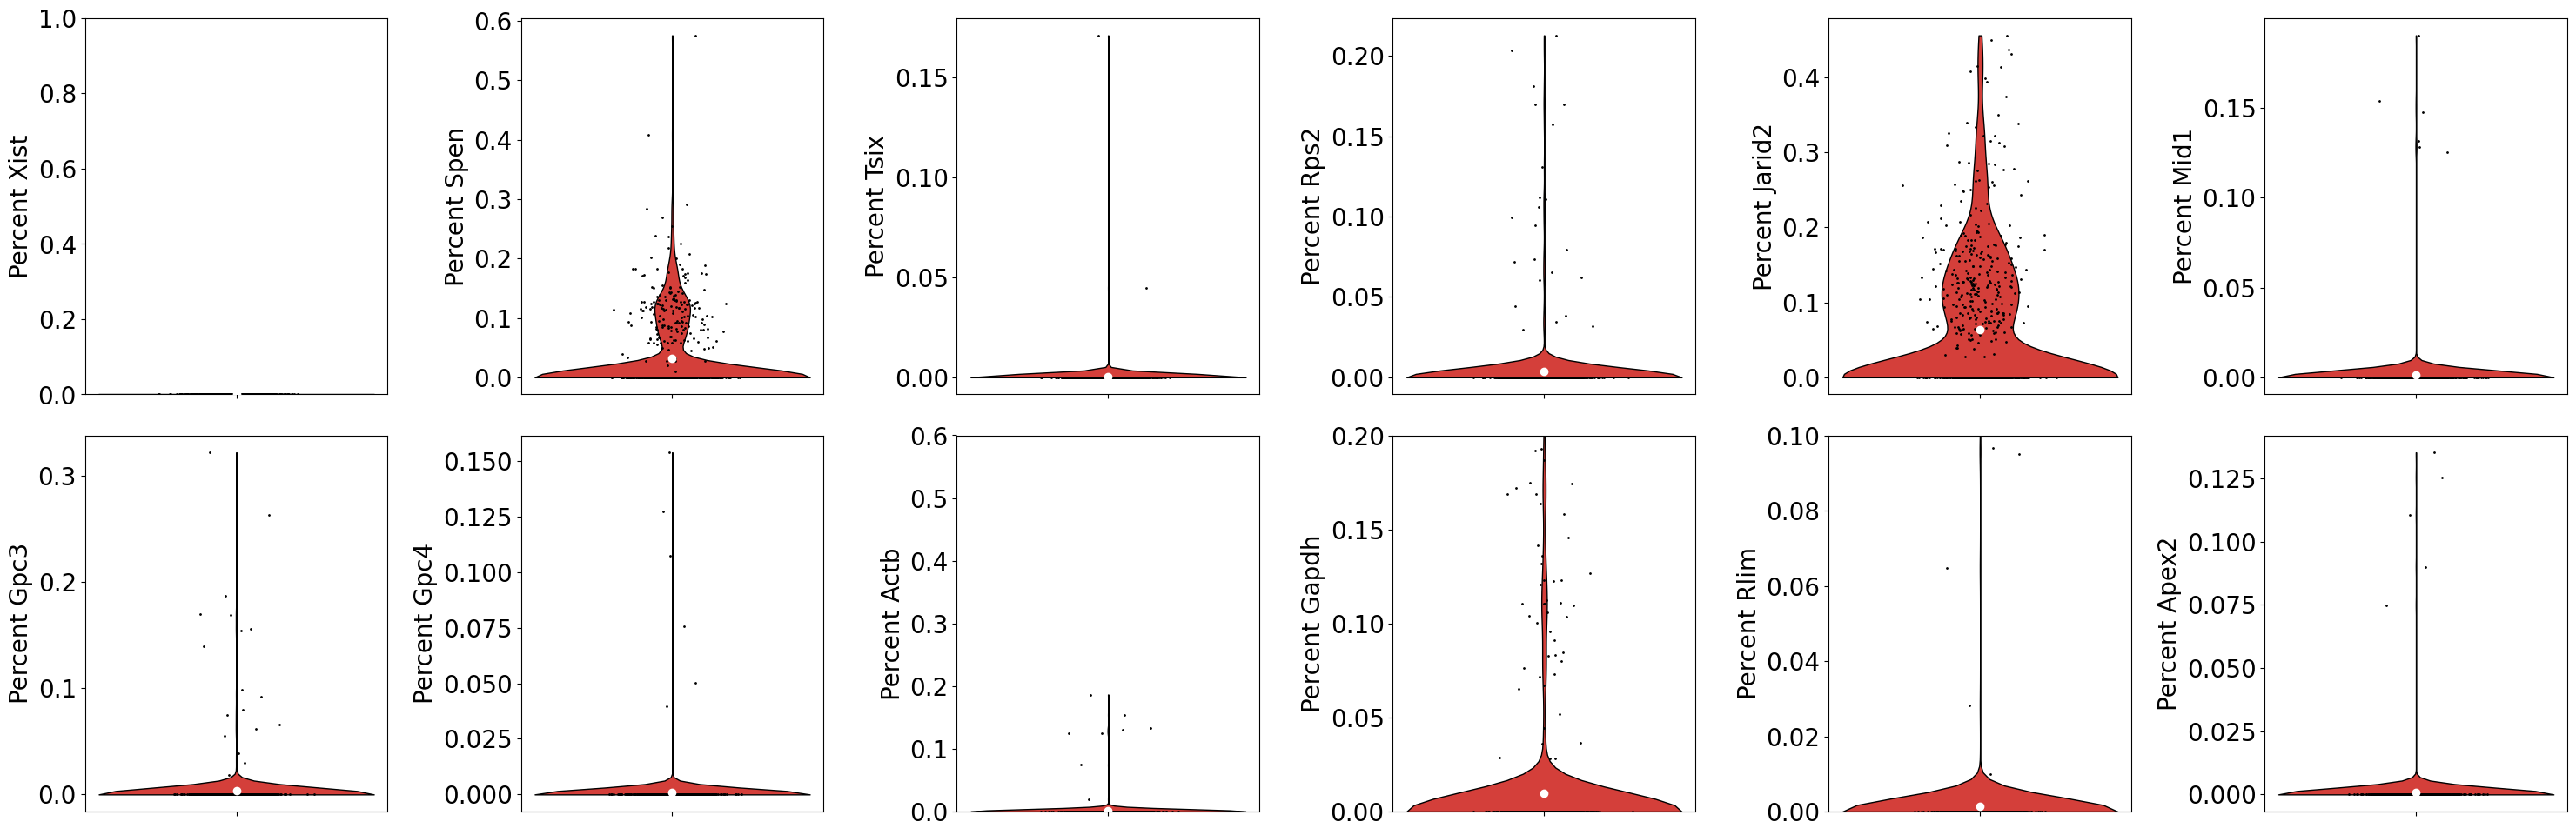

In [132]:
filtered_data = adata_1[adata_1.obs['id'].str.endswith('[RTBC1]')].copy()
adata_ = filtered_data.copy()

# List of genes

gene1 = 'Xist'
gene2 = 'Spen'
gene3 = 'Tsix'
gene4 = 'Rps2'
gene5 = 'Jarid2'
gene6 = 'Mid1'
gene7 = 'Gpc3'
gene8 = 'Gpc4'
gene9 = 'Actb'
gene10 = 'Gapdh'
gene11 = 'Rlim'
gene12 = 'Apex2'

fig, ax = plt.subplots(figsize=(5*6,5*2), ncols=6, nrows=1*2)
x1 = np.squeeze(np.asarray((adata_[:,gene1].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x2 = np.squeeze(np.asarray((adata_[:,gene2].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x3 = np.squeeze(np.asarray((adata_[:,gene3].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x4 = np.squeeze(np.asarray((adata_[:,gene4].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x5 = np.squeeze(np.asarray((adata_[:,gene5].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x6 = np.squeeze(np.asarray((adata_[:,gene6].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x7 = np.squeeze(np.asarray((adata_[:,gene7].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x8 = np.squeeze(np.asarray((adata_[:,gene8].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x9 = np.squeeze(np.asarray((adata_[:,gene9].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x10 = np.squeeze(np.asarray((adata_[:,gene10].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x11 = np.squeeze(np.asarray((adata_[:,gene11].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x12 = np.squeeze(np.asarray((adata_[:,gene12].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
vplot(x1, ax[0][0])
vplot(x2, ax[0][1])
vplot(x3, ax[0][2])
vplot(x4, ax[0][3])
vplot(x5, ax[0][4])
vplot(x6, ax[0][5])
vplot(x7, ax[1][0])
vplot(x8, ax[1][1])
vplot(x9, ax[1][2])
vplot(x10, ax[1][3])
vplot(x11, ax[1][4])
vplot(x12, ax[1][5])
ax[0][0].set_ylabel("Percent " + gene1)
ax[0][1].set_ylabel("Percent " + gene2)
ax[0][2].set_ylabel("Percent " + gene3)
ax[0][3].set_ylabel("Percent " + gene4)
ax[0][4].set_ylabel("Percent " + gene5)
ax[0][5].set_ylabel("Percent " + gene6)
ax[1][0].set_ylabel("Percent " + gene7)
ax[1][1].set_ylabel("Percent " + gene8)
ax[1][2].set_ylabel("Percent " + gene9)
ax[1][3].set_ylabel("Percent " + gene10)
ax[1][4].set_ylabel("Percent " + gene11)
ax[1][5].set_ylabel("Percent " + gene12)

# Adjust the below to fix the scale on a specific violin

ax[0][0].set_ylim(0,1)
ax[1][3].set_ylim(0,0.2)
ax[1][2].set_ylim(0,0.6)
ax[1][4].set_ylim(0,0.1)

plt.tight_layout()
plt.show()

### Species 2 (129)

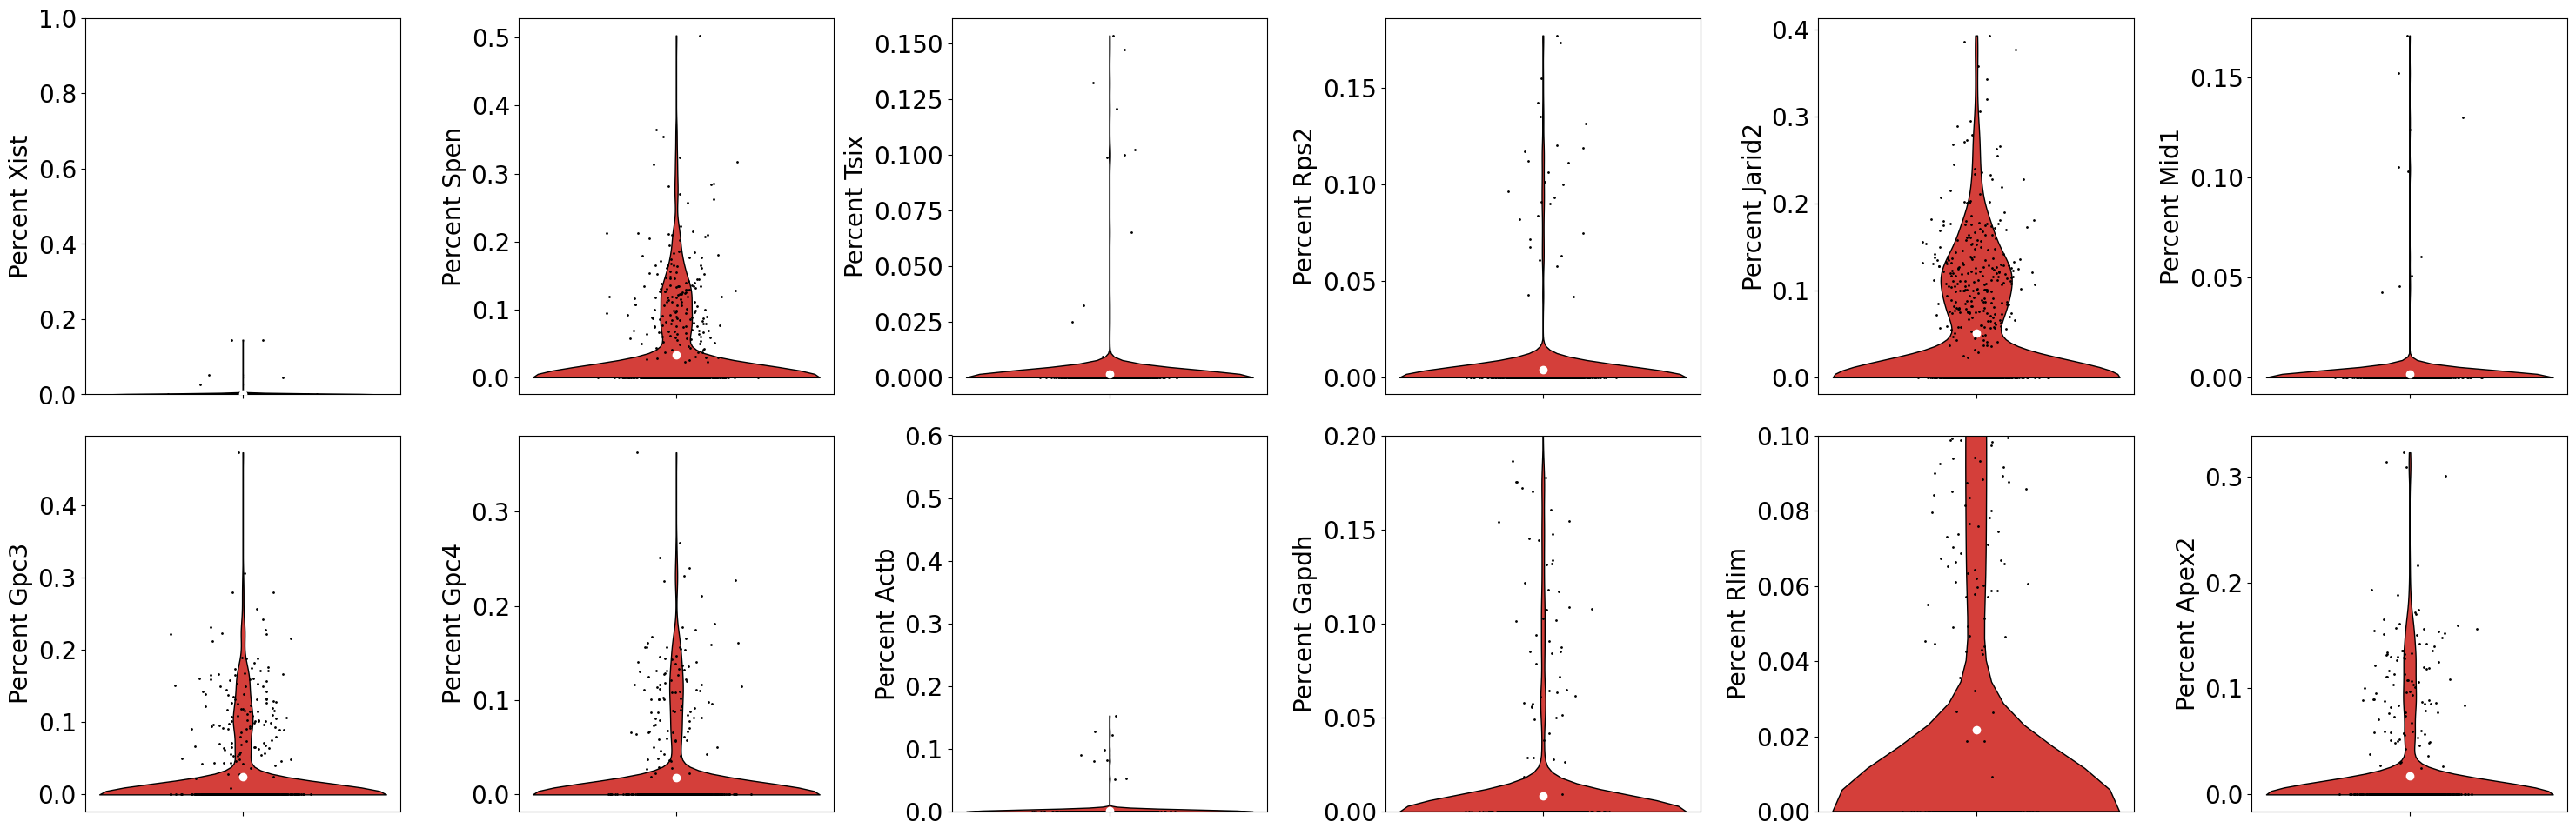

In [133]:
filtered_data = adata_2[adata_2.obs['id'].str.endswith('[RTBC1]')].copy()
adata_ = filtered_data.copy()

# List of genes

gene1 = 'Xist'
gene2 = 'Spen'
gene3 = 'Tsix'
gene4 = 'Rps2'
gene5 = 'Jarid2'
gene6 = 'Mid1'
gene7 = 'Gpc3'
gene8 = 'Gpc4'
gene9 = 'Actb'
gene10 = 'Gapdh'
gene11 = 'Rlim'
gene12 = 'Apex2'

fig, ax = plt.subplots(figsize=(5*6,5*2), ncols=6, nrows=1*2)
x1 = np.squeeze(np.asarray((adata_[:,gene1].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x2 = np.squeeze(np.asarray((adata_[:,gene2].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x3 = np.squeeze(np.asarray((adata_[:,gene3].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x4 = np.squeeze(np.asarray((adata_[:,gene4].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x5 = np.squeeze(np.asarray((adata_[:,gene5].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x6 = np.squeeze(np.asarray((adata_[:,gene6].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x7 = np.squeeze(np.asarray((adata_[:,gene7].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x8 = np.squeeze(np.asarray((adata_[:,gene8].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x9 = np.squeeze(np.asarray((adata_[:,gene9].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x10 = np.squeeze(np.asarray((adata_[:,gene10].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x11 = np.squeeze(np.asarray((adata_[:,gene11].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x12 = np.squeeze(np.asarray((adata_[:,gene12].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
vplot(x1, ax[0][0])
vplot(x2, ax[0][1])
vplot(x3, ax[0][2])
vplot(x4, ax[0][3])
vplot(x5, ax[0][4])
vplot(x6, ax[0][5])
vplot(x7, ax[1][0])
vplot(x8, ax[1][1])
vplot(x9, ax[1][2])
vplot(x10, ax[1][3])
vplot(x11, ax[1][4])
vplot(x12, ax[1][5])
ax[0][0].set_ylabel("Percent " + gene1)
ax[0][1].set_ylabel("Percent " + gene2)
ax[0][2].set_ylabel("Percent " + gene3)
ax[0][3].set_ylabel("Percent " + gene4)
ax[0][4].set_ylabel("Percent " + gene5)
ax[0][5].set_ylabel("Percent " + gene6)
ax[1][0].set_ylabel("Percent " + gene7)
ax[1][1].set_ylabel("Percent " + gene8)
ax[1][2].set_ylabel("Percent " + gene9)
ax[1][3].set_ylabel("Percent " + gene10)
ax[1][4].set_ylabel("Percent " + gene11)
ax[1][5].set_ylabel("Percent " + gene12)

# Adjust the below to fix the scale on a specific violin

ax[0][0].set_ylim(0,1)
ax[1][3].set_ylim(0,0.2)
ax[1][2].set_ylim(0,0.6)
ax[1][4].set_ylim(0,0.1)

plt.tight_layout()
plt.show()

## RTBC2 through RTBC6

### Total

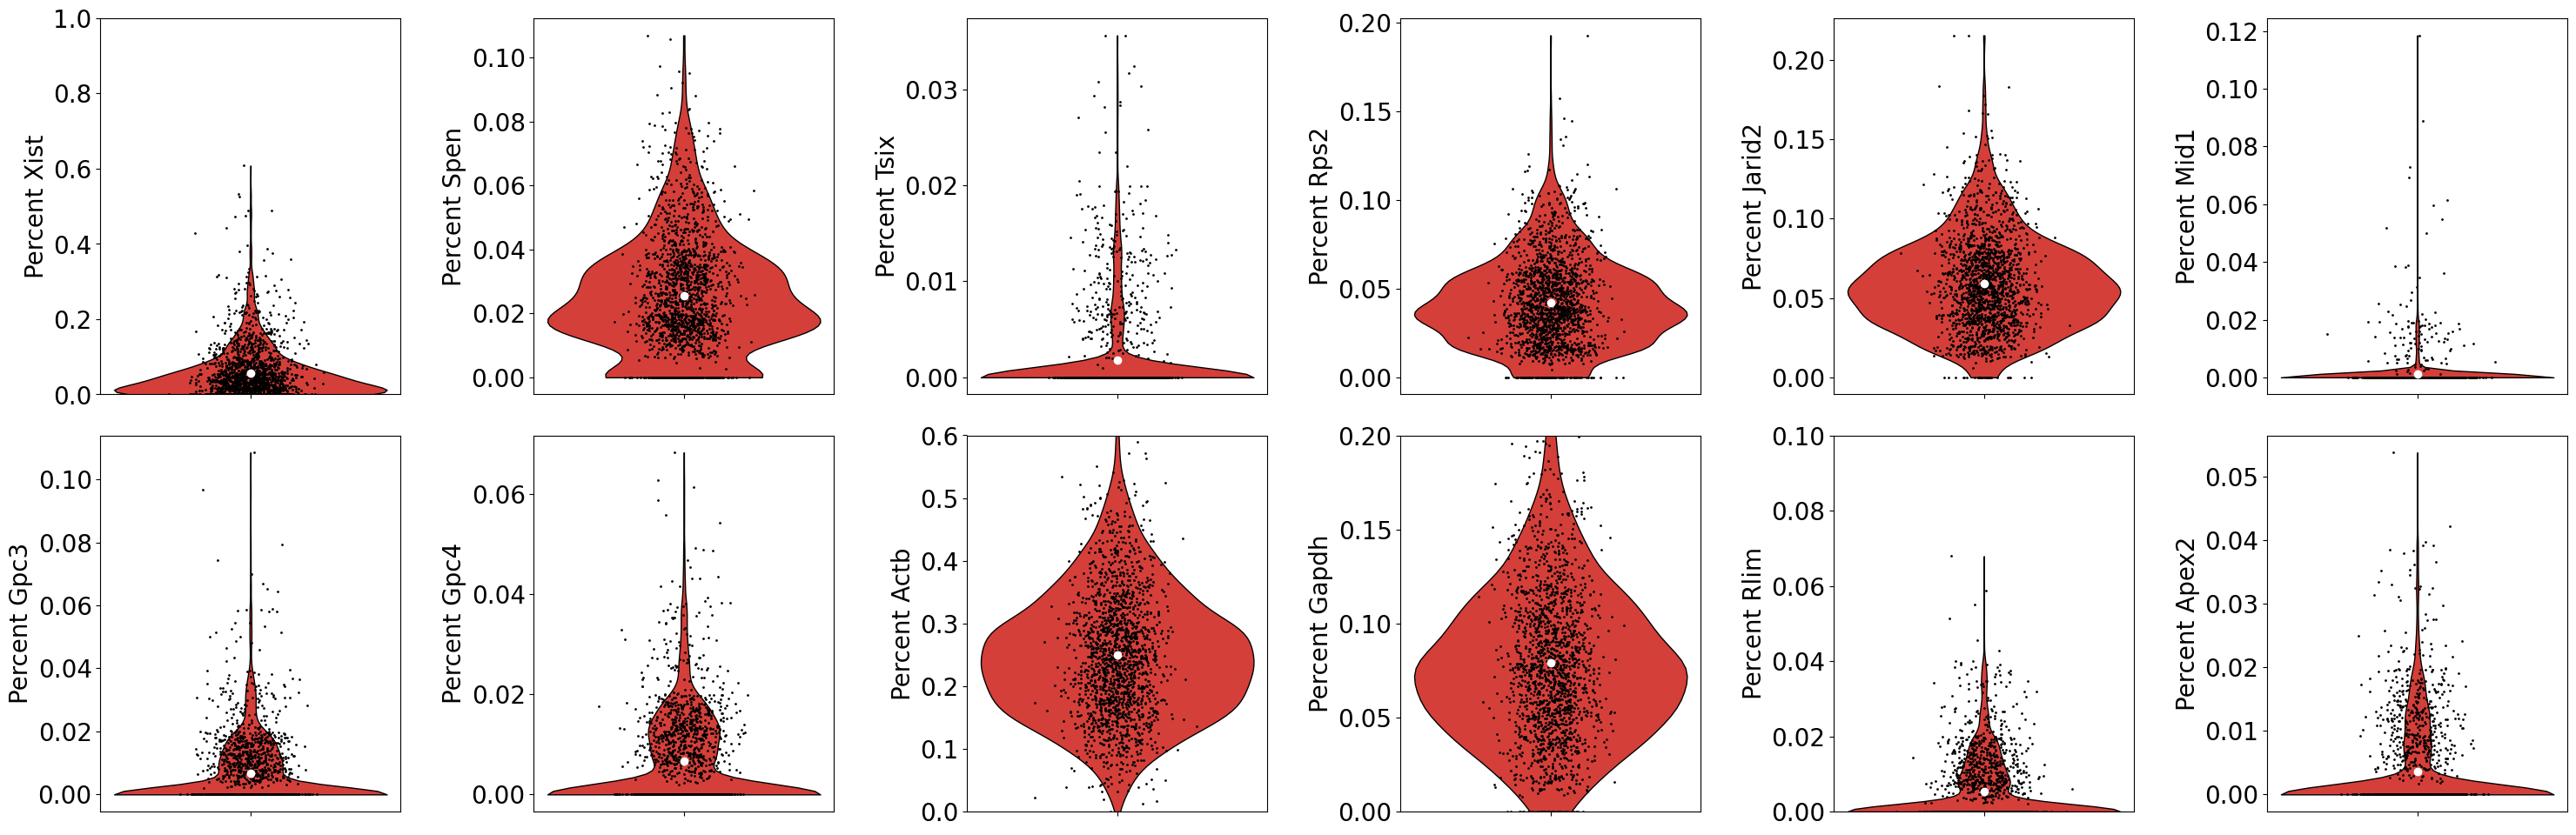

In [136]:
filtered_data = adata.copy()

# Can omit the next few lines if want to use everything
filter_for_tags = "RTBC2,RTBC3,RTBC4,RTBC5,RTBC6"
filter_for_tags_final = ['[' + item + ']' for item in filter_for_tags.split(',')]
if filter_for_tags.strip():
    final = []
    for tag in filter_for_tags_final:
        final.extend([x for x in list(np.array(data.obs['id'])) if tag in x])
    filtered_data = filtered_data[filtered_data.obs['id'].isin(final),:]

adata_ = filtered_data.copy()

# List of genes

gene1 = 'Xist'
gene2 = 'Spen'
gene3 = 'Tsix'
gene4 = 'Rps2'
gene5 = 'Jarid2'
gene6 = 'Mid1'
gene7 = 'Gpc3'
gene8 = 'Gpc4'
gene9 = 'Actb'
gene10 = 'Gapdh'
gene11 = 'Rlim'
gene12 = 'Apex2'

fig, ax = plt.subplots(figsize=(5*6,5*2), ncols=6, nrows=1*2)
x1 = np.squeeze(np.asarray((adata_[:,gene1].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x2 = np.squeeze(np.asarray((adata_[:,gene2].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x3 = np.squeeze(np.asarray((adata_[:,gene3].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x4 = np.squeeze(np.asarray((adata_[:,gene4].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x5 = np.squeeze(np.asarray((adata_[:,gene5].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x6 = np.squeeze(np.asarray((adata_[:,gene6].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x7 = np.squeeze(np.asarray((adata_[:,gene7].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x8 = np.squeeze(np.asarray((adata_[:,gene8].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x9 = np.squeeze(np.asarray((adata_[:,gene9].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x10 = np.squeeze(np.asarray((adata_[:,gene10].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x11 = np.squeeze(np.asarray((adata_[:,gene11].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x12 = np.squeeze(np.asarray((adata_[:,gene12].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
vplot(x1, ax[0][0])
vplot(x2, ax[0][1])
vplot(x3, ax[0][2])
vplot(x4, ax[0][3])
vplot(x5, ax[0][4])
vplot(x6, ax[0][5])
vplot(x7, ax[1][0])
vplot(x8, ax[1][1])
vplot(x9, ax[1][2])
vplot(x10, ax[1][3])
vplot(x11, ax[1][4])
vplot(x12, ax[1][5])
ax[0][0].set_ylabel("Percent " + gene1)
ax[0][1].set_ylabel("Percent " + gene2)
ax[0][2].set_ylabel("Percent " + gene3)
ax[0][3].set_ylabel("Percent " + gene4)
ax[0][4].set_ylabel("Percent " + gene5)
ax[0][5].set_ylabel("Percent " + gene6)
ax[1][0].set_ylabel("Percent " + gene7)
ax[1][1].set_ylabel("Percent " + gene8)
ax[1][2].set_ylabel("Percent " + gene9)
ax[1][3].set_ylabel("Percent " + gene10)
ax[1][4].set_ylabel("Percent " + gene11)
ax[1][5].set_ylabel("Percent " + gene12)

# Adjust the below to fix the scale on a specific violin

ax[0][0].set_ylim(0,1)
ax[1][3].set_ylim(0,0.2)
ax[1][2].set_ylim(0,0.6)
ax[1][4].set_ylim(0,0.1)

plt.tight_layout()
plt.show()

### Species 1 (CAST)

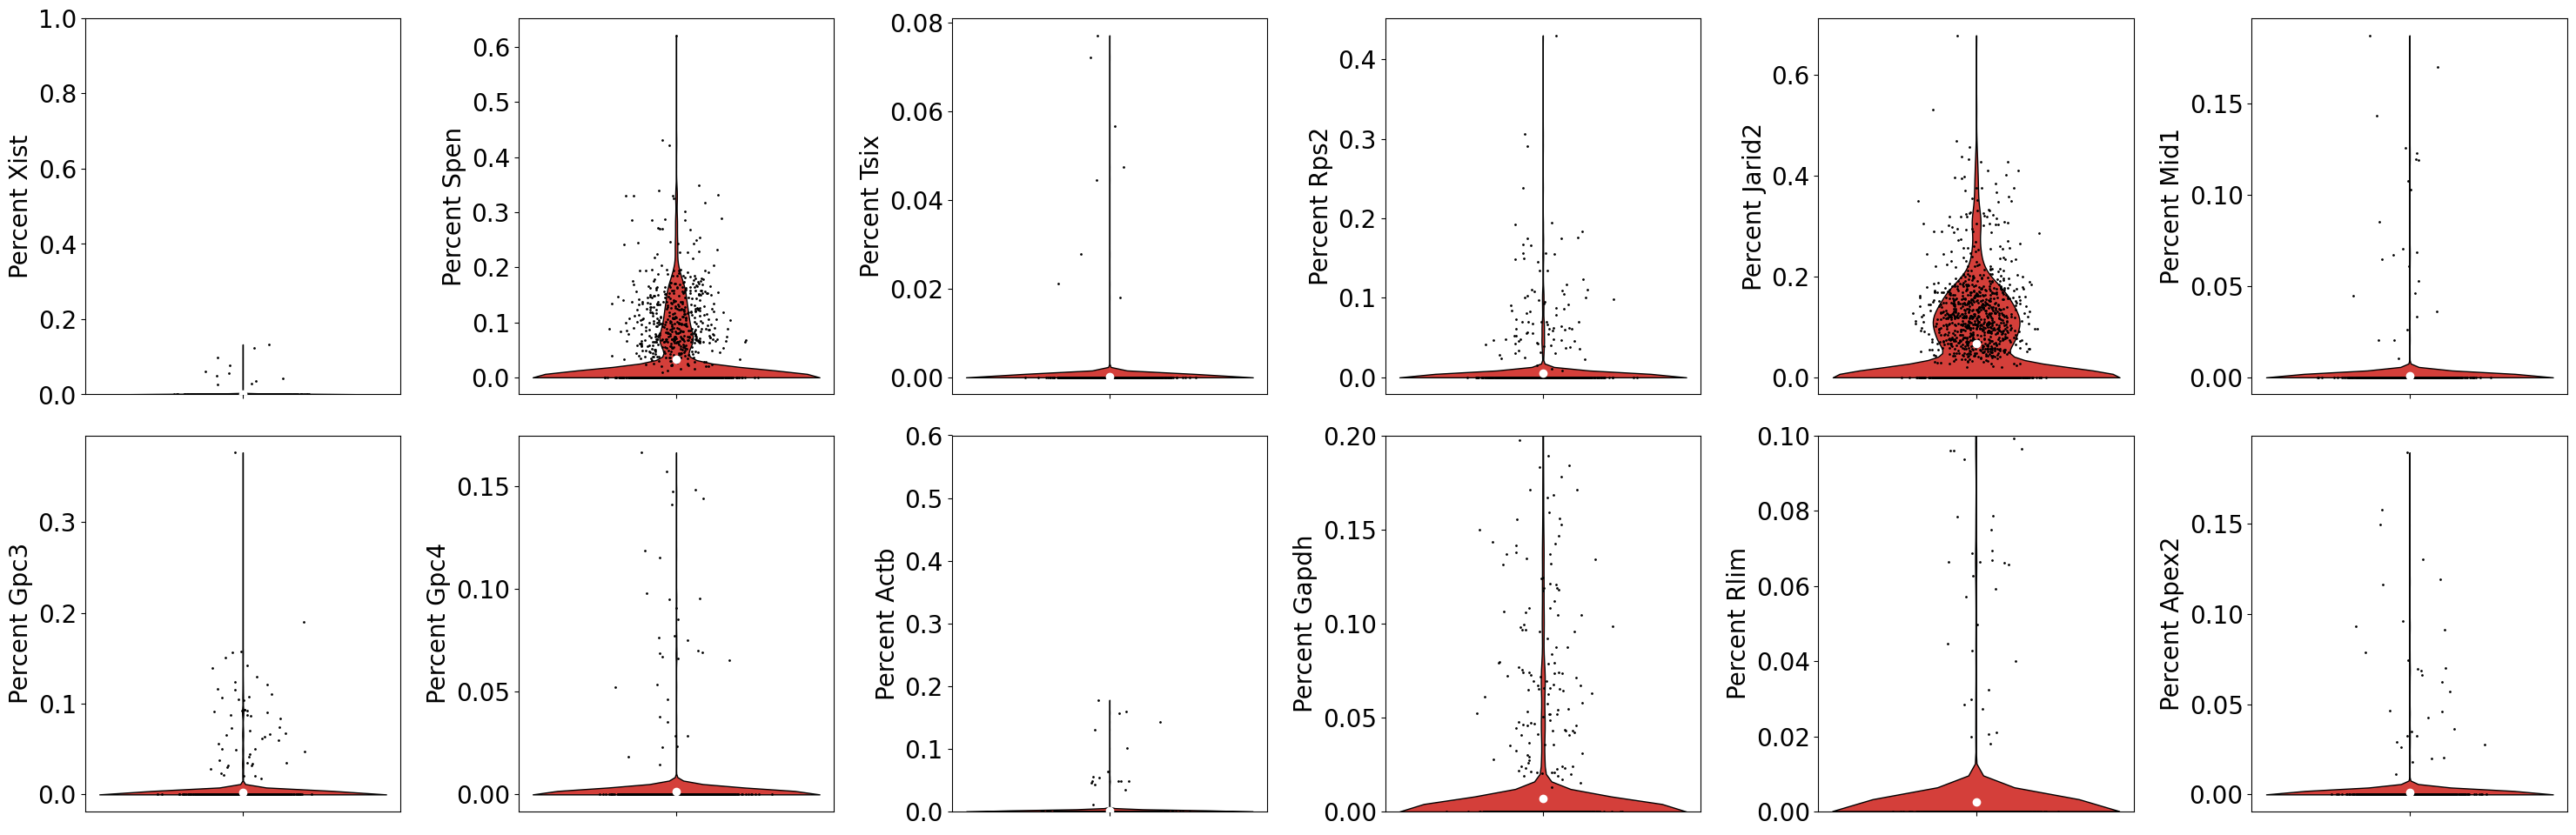

In [137]:
filtered_data = adata_1.copy()

# Can omit the next few lines if want to use everything
filter_for_tags = "RTBC2,RTBC3,RTBC4,RTBC5,RTBC6"
filter_for_tags_final = ['[' + item + ']' for item in filter_for_tags.split(',')]
if filter_for_tags.strip():
    final = []
    for tag in filter_for_tags_final:
        final.extend([x for x in list(np.array(data.obs['id'])) if tag in x])
    filtered_data = filtered_data[filtered_data.obs['id'].isin(final),:]

adata_ = filtered_data.copy()

# List of genes

gene1 = 'Xist'
gene2 = 'Spen'
gene3 = 'Tsix'
gene4 = 'Rps2'
gene5 = 'Jarid2'
gene6 = 'Mid1'
gene7 = 'Gpc3'
gene8 = 'Gpc4'
gene9 = 'Actb'
gene10 = 'Gapdh'
gene11 = 'Rlim'
gene12 = 'Apex2'

fig, ax = plt.subplots(figsize=(5*6,5*2), ncols=6, nrows=1*2)
x1 = np.squeeze(np.asarray((adata_[:,gene1].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x2 = np.squeeze(np.asarray((adata_[:,gene2].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x3 = np.squeeze(np.asarray((adata_[:,gene3].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x4 = np.squeeze(np.asarray((adata_[:,gene4].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x5 = np.squeeze(np.asarray((adata_[:,gene5].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x6 = np.squeeze(np.asarray((adata_[:,gene6].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x7 = np.squeeze(np.asarray((adata_[:,gene7].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x8 = np.squeeze(np.asarray((adata_[:,gene8].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x9 = np.squeeze(np.asarray((adata_[:,gene9].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x10 = np.squeeze(np.asarray((adata_[:,gene10].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x11 = np.squeeze(np.asarray((adata_[:,gene11].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x12 = np.squeeze(np.asarray((adata_[:,gene12].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
vplot(x1, ax[0][0])
vplot(x2, ax[0][1])
vplot(x3, ax[0][2])
vplot(x4, ax[0][3])
vplot(x5, ax[0][4])
vplot(x6, ax[0][5])
vplot(x7, ax[1][0])
vplot(x8, ax[1][1])
vplot(x9, ax[1][2])
vplot(x10, ax[1][3])
vplot(x11, ax[1][4])
vplot(x12, ax[1][5])
ax[0][0].set_ylabel("Percent " + gene1)
ax[0][1].set_ylabel("Percent " + gene2)
ax[0][2].set_ylabel("Percent " + gene3)
ax[0][3].set_ylabel("Percent " + gene4)
ax[0][4].set_ylabel("Percent " + gene5)
ax[0][5].set_ylabel("Percent " + gene6)
ax[1][0].set_ylabel("Percent " + gene7)
ax[1][1].set_ylabel("Percent " + gene8)
ax[1][2].set_ylabel("Percent " + gene9)
ax[1][3].set_ylabel("Percent " + gene10)
ax[1][4].set_ylabel("Percent " + gene11)
ax[1][5].set_ylabel("Percent " + gene12)

# Adjust the below to fix the scale on a specific violin

ax[0][0].set_ylim(0,1)
ax[1][3].set_ylim(0,0.2)
ax[1][2].set_ylim(0,0.6)
ax[1][4].set_ylim(0,0.1)

plt.tight_layout()
plt.show()

### Species 2 (129)

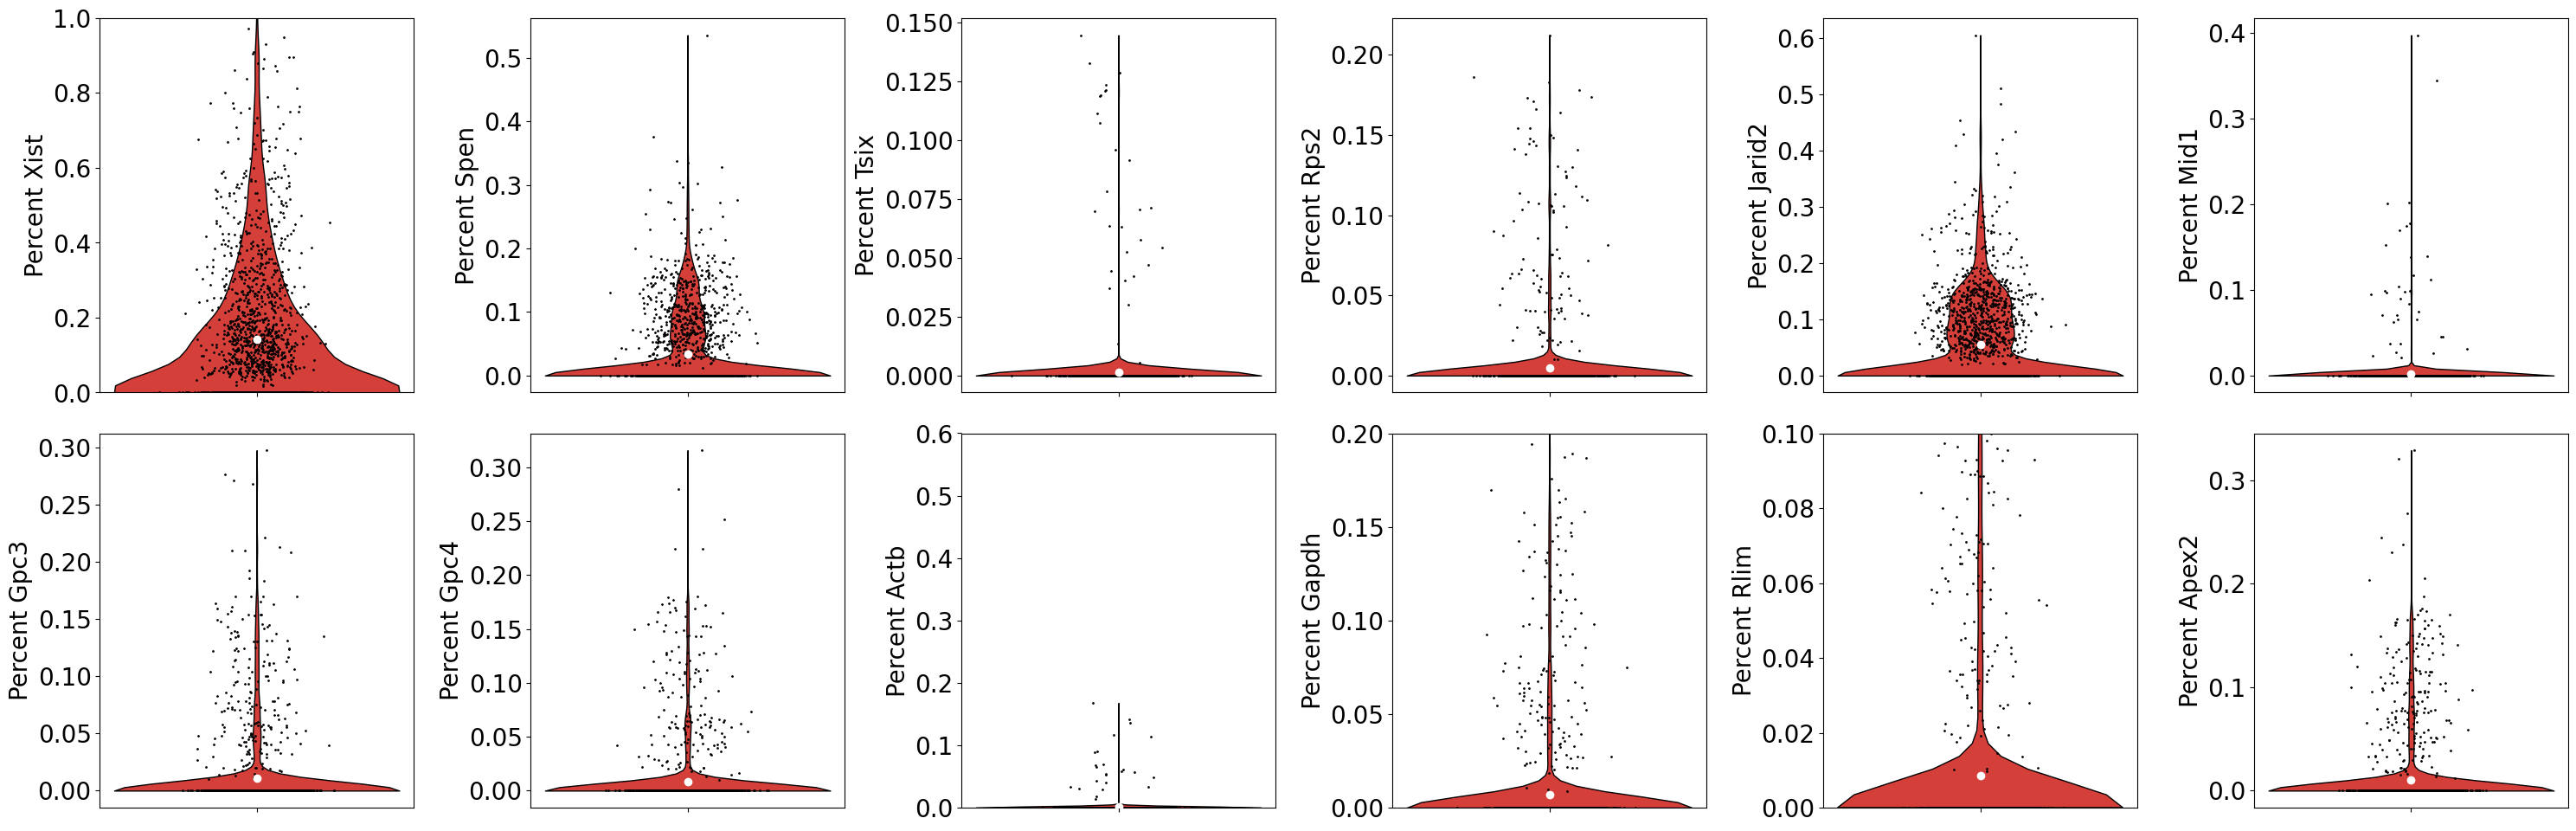

In [138]:
filtered_data = adata_2.copy()

# Can omit the next few lines if want to use everything
filter_for_tags = "RTBC2,RTBC3,RTBC4,RTBC5,RTBC6"
filter_for_tags_final = ['[' + item + ']' for item in filter_for_tags.split(',')]
if filter_for_tags.strip():
    final = []
    for tag in filter_for_tags_final:
        final.extend([x for x in list(np.array(data.obs['id'])) if tag in x])
    filtered_data = filtered_data[filtered_data.obs['id'].isin(final),:]

adata_ = filtered_data.copy()

# List of genes

gene1 = 'Xist'
gene2 = 'Spen'
gene3 = 'Tsix'
gene4 = 'Rps2'
gene5 = 'Jarid2'
gene6 = 'Mid1'
gene7 = 'Gpc3'
gene8 = 'Gpc4'
gene9 = 'Actb'
gene10 = 'Gapdh'
gene11 = 'Rlim'
gene12 = 'Apex2'

fig, ax = plt.subplots(figsize=(5*6,5*2), ncols=6, nrows=1*2)
x1 = np.squeeze(np.asarray((adata_[:,gene1].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x2 = np.squeeze(np.asarray((adata_[:,gene2].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x3 = np.squeeze(np.asarray((adata_[:,gene3].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x4 = np.squeeze(np.asarray((adata_[:,gene4].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x5 = np.squeeze(np.asarray((adata_[:,gene5].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x6 = np.squeeze(np.asarray((adata_[:,gene6].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x7 = np.squeeze(np.asarray((adata_[:,gene7].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x8 = np.squeeze(np.asarray((adata_[:,gene8].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x9 = np.squeeze(np.asarray((adata_[:,gene9].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x10 = np.squeeze(np.asarray((adata_[:,gene10].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x11 = np.squeeze(np.asarray((adata_[:,gene11].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
x12 = np.squeeze(np.asarray((adata_[:,gene12].X.sum(axis=1)/adata_.X.sum(axis=1)*100)))
vplot(x1, ax[0][0])
vplot(x2, ax[0][1])
vplot(x3, ax[0][2])
vplot(x4, ax[0][3])
vplot(x5, ax[0][4])
vplot(x6, ax[0][5])
vplot(x7, ax[1][0])
vplot(x8, ax[1][1])
vplot(x9, ax[1][2])
vplot(x10, ax[1][3])
vplot(x11, ax[1][4])
vplot(x12, ax[1][5])
ax[0][0].set_ylabel("Percent " + gene1)
ax[0][1].set_ylabel("Percent " + gene2)
ax[0][2].set_ylabel("Percent " + gene3)
ax[0][3].set_ylabel("Percent " + gene4)
ax[0][4].set_ylabel("Percent " + gene5)
ax[0][5].set_ylabel("Percent " + gene6)
ax[1][0].set_ylabel("Percent " + gene7)
ax[1][1].set_ylabel("Percent " + gene8)
ax[1][2].set_ylabel("Percent " + gene9)
ax[1][3].set_ylabel("Percent " + gene10)
ax[1][4].set_ylabel("Percent " + gene11)
ax[1][5].set_ylabel("Percent " + gene12)

# Adjust the below to fix the scale on a specific violin

ax[0][0].set_ylim(0,1)
ax[1][3].set_ylim(0,0.2)
ax[1][2].set_ylim(0,0.6)
ax[1][4].set_ylim(0,0.1)

plt.tight_layout()
plt.show()

## Allele scatter plots for individual genes

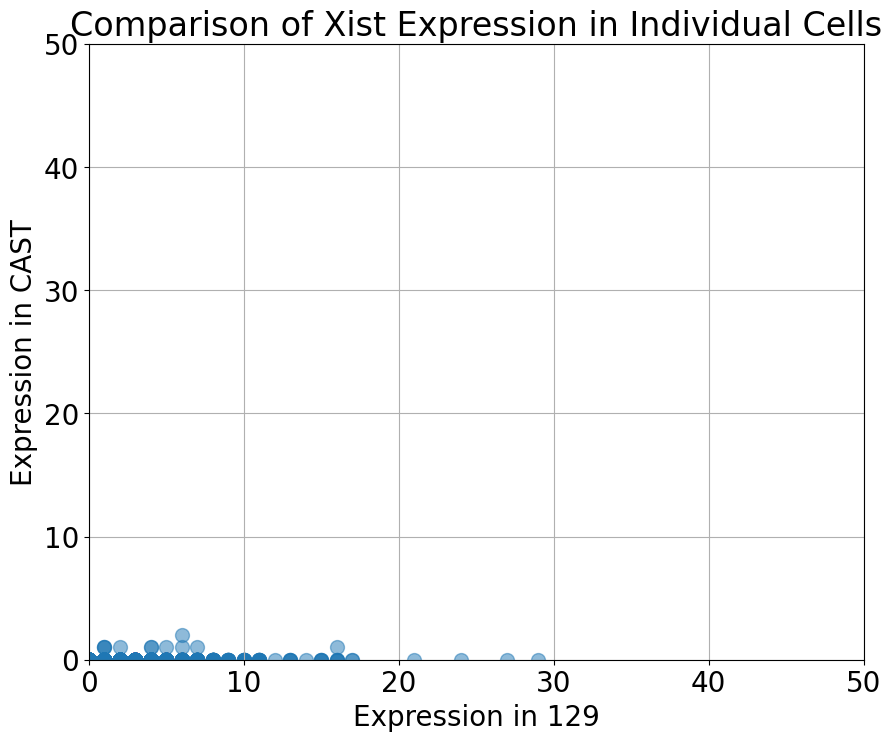

In [143]:
gene="Xist"
allele_data_1 = adata_1[:, gene].X.toarray().flatten()
allele_data_2 = adata_2[:, gene].X.toarray().flatten()

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(allele_data_2, allele_data_1, alpha=0.5, s=100)  # alpha for transparency
plt.title('Comparison of ' + gene + ' Expression in Individual Cells')
plt.xlabel('Expression in 129')
plt.ylabel('Expression in CAST')
plt.grid(True)
plt.ylim(0,50)
plt.xlim(0,50)
plt.show()


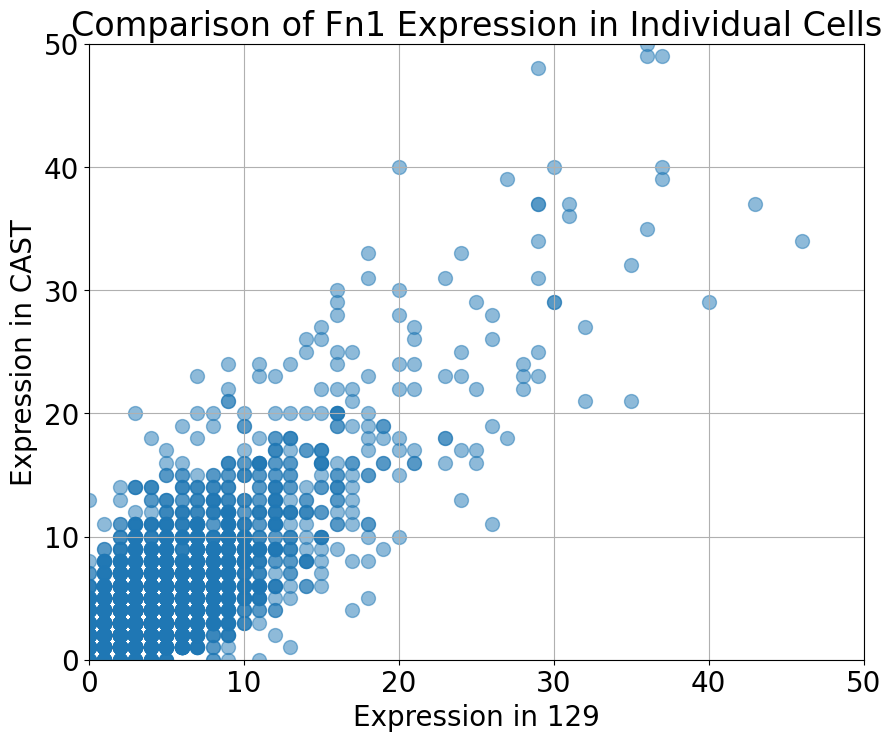

In [144]:
gene="Fn1"
allele_data_1 = adata_1[:, gene].X.toarray().flatten()
allele_data_2 = adata_2[:, gene].X.toarray().flatten()

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(allele_data_2, allele_data_1, alpha=0.5, s=100)  # alpha for transparency
plt.title('Comparison of ' + gene + ' Expression in Individual Cells')
plt.xlabel('Expression in 129')
plt.ylabel('Expression in CAST')
plt.grid(True)
plt.ylim(0,50)
plt.xlim(0,50)
plt.show()


# Highly variable genes for the total AnnData

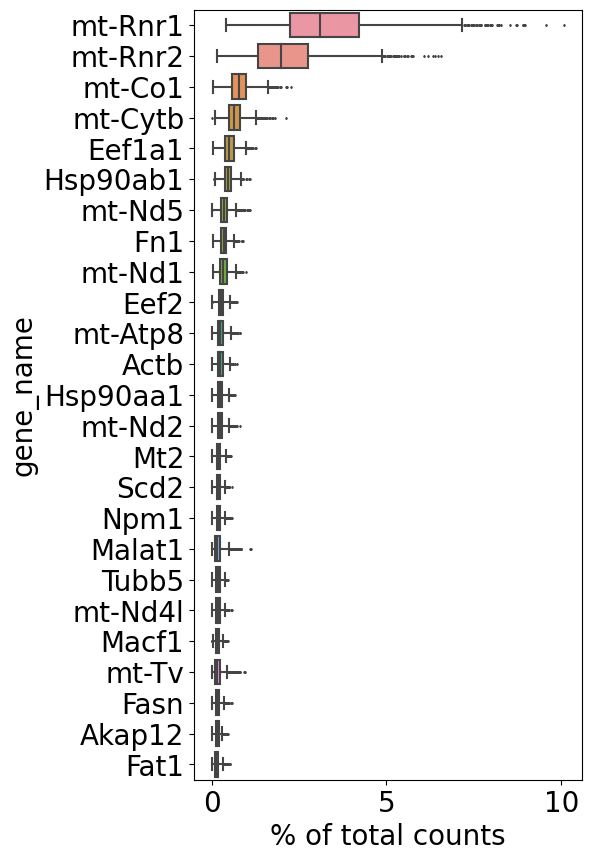

In [149]:
fig, ax = plt.subplots(figsize=(5, 10))
sc.pl.highest_expr_genes(adata, n_top=25, ax = ax, gene_symbols="gene_name")

## Scatter plot of pair-wise gene expression (normalized as counts per million) in total AnnData

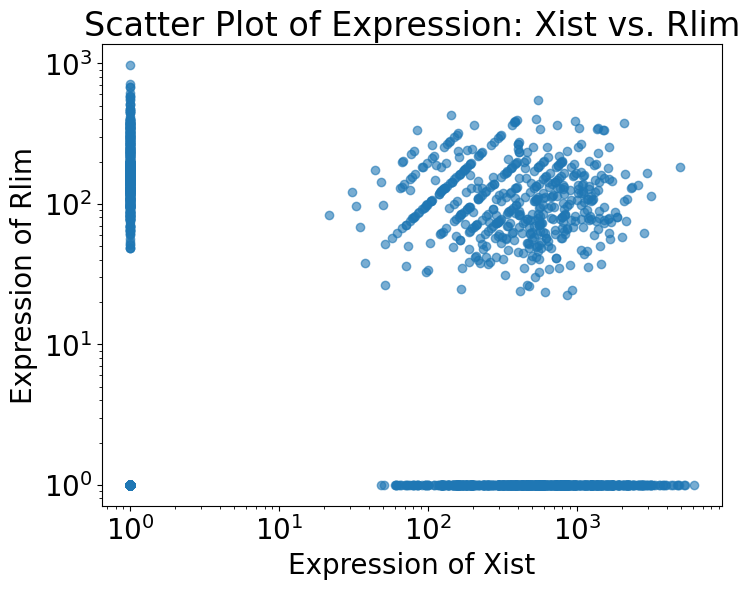

In [160]:
_xdata = adata.copy()
gene_x = 'Xist'
gene_y = 'Rlim'

cpm_matrix = _xdata.X.copy()


if scipy.sparse.issparse(_xdata.X):
    total_counts_per_cell = np.array(_xdata.X.sum(axis=1)).flatten()
else:
    total_counts_per_cell = _xdata.X.sum(axis=1)

total_counts_per_cell[total_counts_per_cell == 0] = np.nan

# Step 2 and 3: Normalize counts to CPM

if scipy.sparse.issparse(cpm_matrix):
    # For sparse matrix, perform operation without densifying the whole matrix
    cpm_matrix = scipy.sparse.csr_matrix(cpm_matrix)
    cpm_matrix.data = cpm_matrix.data / np.repeat(total_counts_per_cell, np.diff(cpm_matrix.indptr)) * 1e6
else:
    # For dense matrix
    cpm_matrix = (cpm_matrix / total_counts_per_cell[:, None]) * 1e6

# Update xdata.X with the normalized CPM values
_xdata.X = cpm_matrix

# Extract expression values for the two genes
# This assumes that gene names are stored in adata.var_names
if scipy.sparse.issparse(_xdata.X):
    # Convert to dense format if the data is stored as a sparse matrix
    X_dense = _xdata.X.toarray()
else:
    X_dense = _xdata.X

# Extracting gene indices
gene_x_idx = np.where(_xdata.var_names == gene_x)[0][0]
gene_y_idx = np.where(_xdata.var_names == gene_y)[0][0]

# Extracting expression values for each gene
expression_x = X_dense[:, gene_x_idx]
expression_y = X_dense[:, gene_y_idx]

# Creating the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(expression_x+1, expression_y+1, alpha=0.6)

plt.title(f'Scatter Plot of Expression: {gene_x} vs. {gene_y}')
plt.xlabel(f'Expression of {gene_x}')
plt.ylabel(f'Expression of {gene_y}')
plt.xscale('log')
plt.yscale('log')
plt.show()


# Heatmap of select genes ordered by Xist expression in total AnnData

(31, 2428)


<Figure size 1200x1400 with 0 Axes>

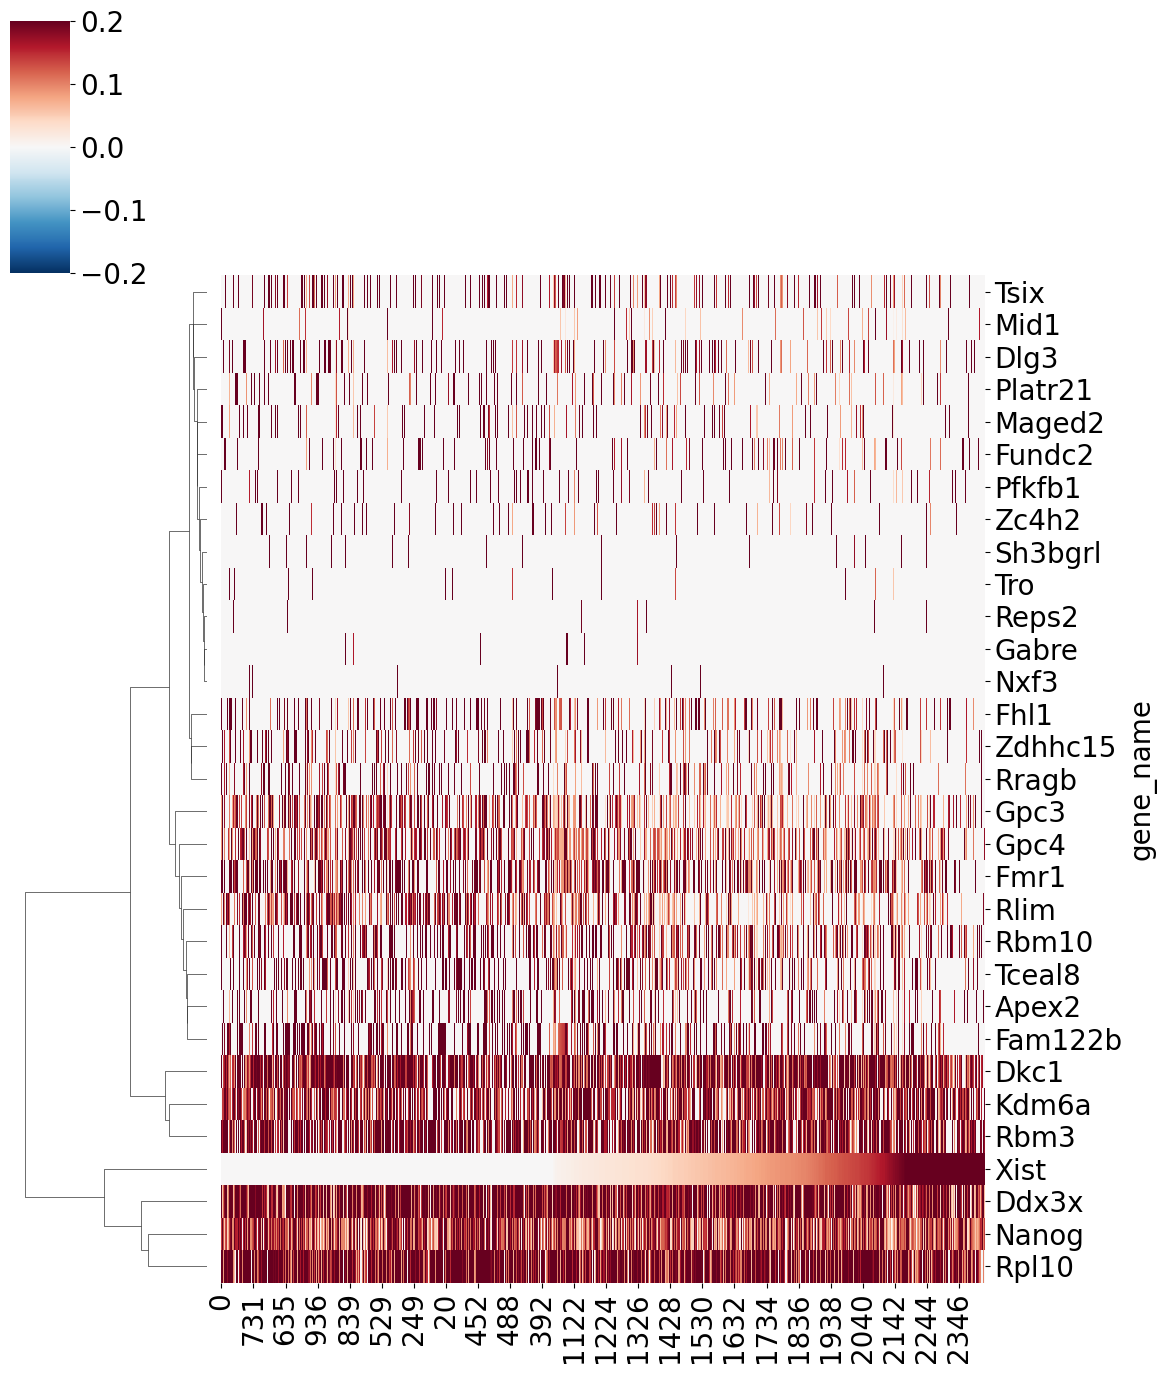

In [158]:
_xdata = adata.copy()
genes_to_keep = ['Xist','Nanog','Kdm6a','Dkc1','Rbm3','Rpl10','Mid1','Rbm10',
                 'Fmr1','Ddx3x','Platr21','Gabre','Pfkfb1','Tsix','Sh3bgrl','Apex2',
                 'Tro','Fhl1','Fam122b','Maged2','Zdhhc15','Reps2','Nxf3','Fundc2','Rragb',
                 'Gpc3','Dlg3','Tceal8','Zc4h2','Gpc4','Rlim']
gene_indices = [_xdata.var_names.get_loc(gene) for gene in genes_to_keep]


if scipy.sparse.issparse(_xdata.X):
    total_counts_per_cell = np.array(_xdata.X.sum(axis=1)).flatten()
else:
    total_counts_per_cell = _xdata.X.sum(axis=1)

total_counts_per_cell[total_counts_per_cell == 0] = np.nan


cpm_matrix = _xdata.X.copy()


# Step 2 and 3: Normalize counts to CPM

if scipy.sparse.issparse(cpm_matrix):
    # For sparse matrix, perform operation without densifying the whole matrix
    cpm_matrix = scipy.sparse.csr_matrix(cpm_matrix)
    cpm_matrix.data = cpm_matrix.data / np.repeat(total_counts_per_cell, np.diff(cpm_matrix.indptr)) * 1e6
else:
    # For dense matrix
    cpm_matrix = (cpm_matrix / total_counts_per_cell[:, None]) * 1e6

# Update xdata.X with the normalized CPM values
_xdata.X = cpm_matrix


# Subset the AnnData object to only include the selected genes
_xdata = _xdata[:, gene_indices]
non_zero_genes = np.array(_xdata.X.T.toarray().sum(axis=1)).flatten() >= 15

xist_gene_expression = _xdata[:, _xdata.var['gene_name'] == 'Xist'].X
if scipy.sparse.issparse(xist_gene_expression):
    xist_gene_expression = xist_gene_expression.toarray().flatten()
else:
    xist_gene_expression = xist_gene_expression.flatten()

# Step 2: Order the cells by "Xist" expression (from low to high)
ordered_cell_indices = np.argsort(xist_gene_expression)

xdata_ordered = _xdata[ordered_cell_indices, non_zero_genes] # non_zero_genes

_xdata = xdata_ordered

xist__expression = _xdata[:, 'Xist'].X  # Extracts the expression values of Xist across all barcodes/cells

# Identify the indices where Xist expression is not zero
#non_zero_xist_indices = xist__expression.nonzero()[0]

# Filter the AnnData object to keep only those barcodes/cells
#adata_filtered = _xdata[non_zero_xist_indices, :]
#xdata_ordered = adata_filtered

# 

# Convert the ordered expression data to a dense DataFrame for plotting
if scipy.sparse.issparse(xdata_ordered.X):
    expr_matrix_dense = xdata_ordered.X.toarray()
else:
    expr_matrix_dense = xdata_ordered.X

genes = xdata_ordered.var['gene_name']
cells = np.array(range(xdata_ordered.n_obs))

#expr_matrix_dense = np.log2(expr_matrix_dense + 1)

z_scores_matrix = zscore(expr_matrix_dense, axis=1)

# Some genes might have constant expression across all cells leading to NaN values in z-scores
# You can handle NaN values as needed, for example, by replacing them with 0
z_scores_matrix = np.nan_to_num(z_scores_matrix)

# Creating a DataFrame with gene names as rows and cells as columns
df_expr = pd.DataFrame(z_scores_matrix.T, index=genes, columns=cells)
df_expr2 = pd.DataFrame(expr_matrix_dense.T, index=genes, columns=cells)


gene_distances = pdist(df_expr, metric='euclidean')

# Perform hierarchical clustering using the Ward method
gene_linkage = linkage(gene_distances, method='ward')

print(df_expr.shape)

max_abs_value = np.abs(df_expr.values).max()


# Step 4: Plot the heatmap
plt.figure(figsize=(12, 14))
#sns.heatmap(df_expr, cmap='viridis', yticklabels=True)
g = sns.clustermap(df_expr2.T.sort_values(by='Xist').T, cmap='RdBu_r', cbar=True,
                   center=0, vmin=-0.2, vmax=0.2, standard_scale=0,
                   row_linkage=gene_linkage, col_cluster=False, figsize=(12, 14), yticklabels=True)
#plt.title('Gene Expression Heatmap Ordered by Xist Expression')
#plt.xlabel('Cells Ordered by Xist Expression')
#plt.ylabel('Genes')
plt.show()


# Heatmap of select genes ordered by RTBC1-6 then by Xist expression in total AnnData

(31, 2428)


<Figure size 1200x1400 with 0 Axes>

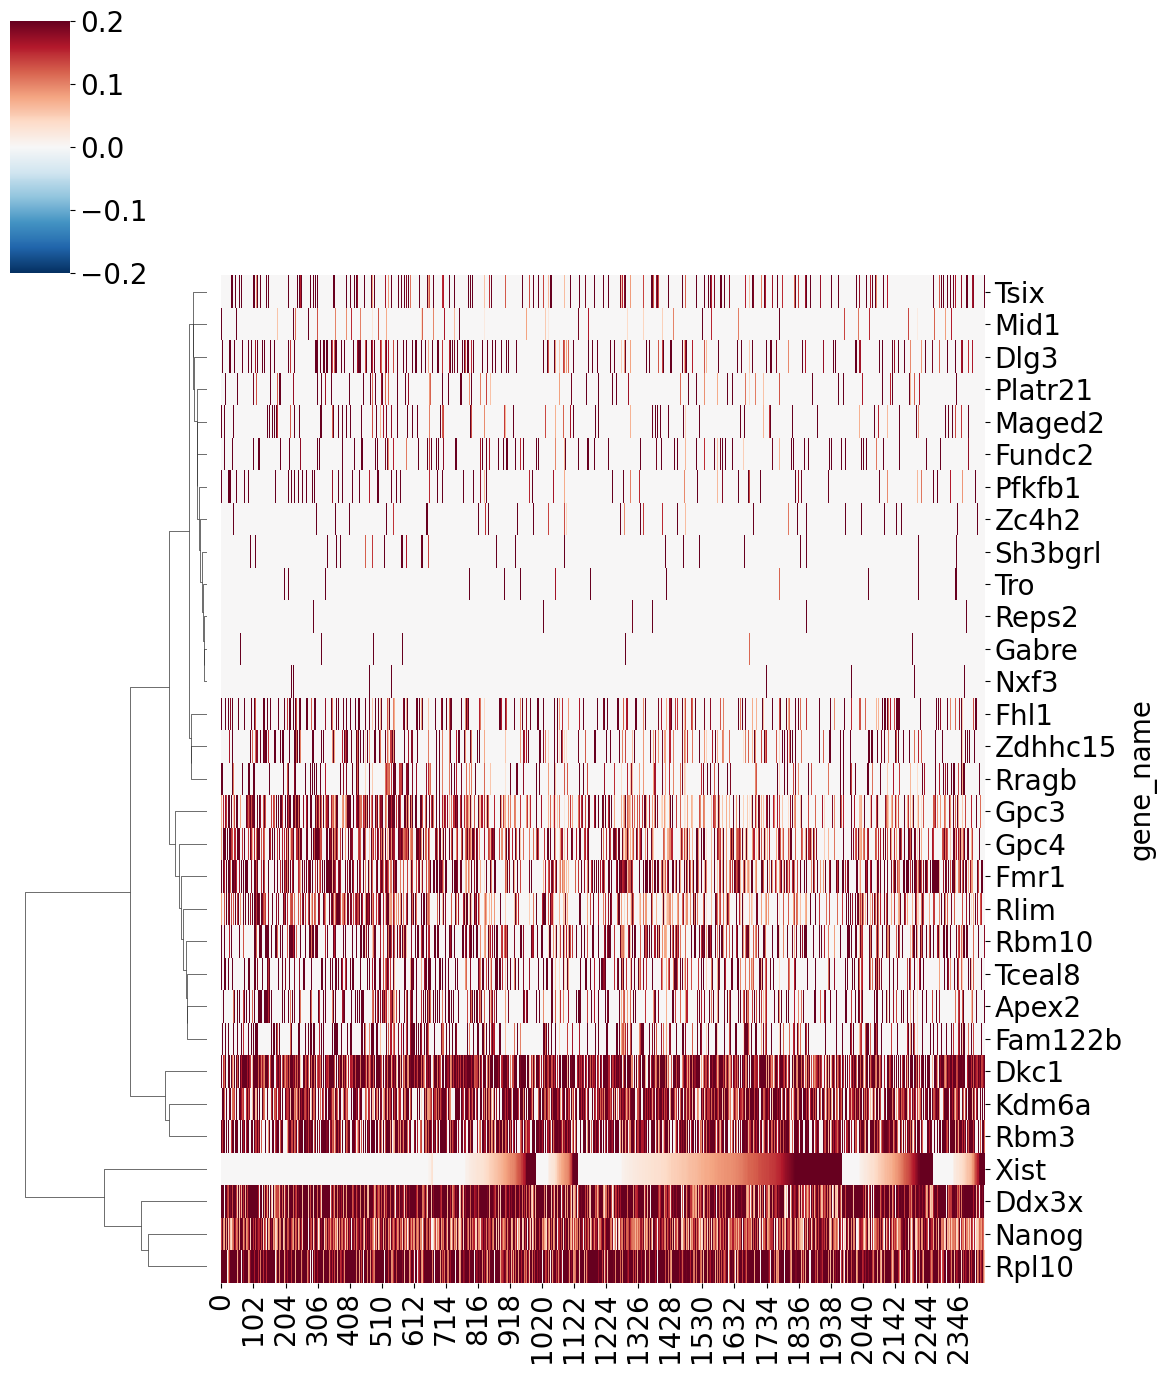

In [162]:
_xdata = adata.copy()
genes_to_keep = ['Xist','Nanog','Kdm6a','Dkc1','Rbm3','Rpl10','Mid1','Rbm10',
                 'Fmr1','Ddx3x','Platr21','Gabre','Pfkfb1','Tsix','Sh3bgrl','Apex2',
                 'Tro','Fhl1','Fam122b','Maged2','Zdhhc15','Reps2','Nxf3','Fundc2','Rragb',
                 'Gpc3','Dlg3','Tceal8','Zc4h2','Gpc4','Rlim']
gene_indices = [_xdata.var_names.get_loc(gene) for gene in genes_to_keep]


if scipy.sparse.issparse(_xdata.X):
    total_counts_per_cell = np.array(_xdata.X.sum(axis=1)).flatten()
else:
    total_counts_per_cell = _xdata.X.sum(axis=1)

total_counts_per_cell[total_counts_per_cell == 0] = np.nan


cpm_matrix = _xdata.X.copy()


# Step 2 and 3: Normalize counts to CPM

if scipy.sparse.issparse(cpm_matrix):
    # For sparse matrix, perform operation without densifying the whole matrix
    cpm_matrix = scipy.sparse.csr_matrix(cpm_matrix)
    cpm_matrix.data = cpm_matrix.data / np.repeat(total_counts_per_cell, np.diff(cpm_matrix.indptr)) * 1e6
else:
    # For dense matrix
    cpm_matrix = (cpm_matrix / total_counts_per_cell[:, None]) * 1e6

# Update xdata.X with the normalized CPM values
_xdata.X = cpm_matrix


# Subset the AnnData object to only include the selected genes
_xdata = _xdata[:, gene_indices]
non_zero_genes = np.array(_xdata.X.T.toarray().sum(axis=1)).flatten() >= 15

xist_gene_expression = _xdata[:, _xdata.var['gene_name'] == 'Xist'].X
if scipy.sparse.issparse(xist_gene_expression):
    xist_gene_expression = xist_gene_expression.toarray().flatten()
else:
    xist_gene_expression = xist_gene_expression.flatten()

# Step 2: Order the cells by "Xist" expression (from low to high)
ordered_cell_indices = np.argsort(xist_gene_expression)

xdata_ordered = _xdata[ordered_cell_indices, non_zero_genes] # non_zero_genes

_xdata = xdata_ordered

xist__expression = _xdata[:, 'Xist'].X  # Extracts the expression values of Xist across all barcodes/cells

# Identify the indices where Xist expression is not zero
#non_zero_xist_indices = xist__expression.nonzero()[0]

# Filter the AnnData object to keep only those barcodes/cells
#adata_filtered = _xdata[non_zero_xist_indices, :]
#xdata_ordered = adata_filtered

# TODO: Filter further!!
xdata_ordered1 = xdata_ordered[xdata_ordered.obs['id'].str.endswith('[RTBC1]')].copy()
xdata_ordered2 = xdata_ordered[xdata_ordered.obs['id'].str.endswith('[RTBC2]')].copy()
xdata_ordered3 = xdata_ordered[xdata_ordered.obs['id'].str.endswith('[RTBC3]')].copy()
xdata_ordered4 = xdata_ordered[xdata_ordered.obs['id'].str.endswith('[RTBC4]')].copy()
xdata_ordered5 = xdata_ordered[xdata_ordered.obs['id'].str.endswith('[RTBC5]')].copy()
xdata_ordered6 = xdata_ordered[xdata_ordered.obs['id'].str.endswith('[RTBC6]')].copy()

adata_combined = xdata_ordered1.copy()
adata_combined = anndata.concat([adata_combined, xdata_ordered2], axis=0, join='outer', merge='same')
adata_combined = anndata.concat([adata_combined, xdata_ordered3], axis=0, join='outer', merge='same')
adata_combined = anndata.concat([adata_combined, xdata_ordered4], axis=0, join='outer', merge='same')
adata_combined = anndata.concat([adata_combined, xdata_ordered5], axis=0, join='outer', merge='same')
adata_combined = anndata.concat([adata_combined, xdata_ordered6], axis=0, join='outer', merge='same')

xdata_ordered = adata_combined.copy()

#xdata_ordered = xdata_ordered1
# 

# Convert the ordered expression data to a dense DataFrame for plotting
if scipy.sparse.issparse(xdata_ordered.X):
    expr_matrix_dense = xdata_ordered.X.toarray()
else:
    expr_matrix_dense = xdata_ordered.X

genes = xdata_ordered.var['gene_name']
cells = np.array(range(xdata_ordered.n_obs))

#expr_matrix_dense = np.log2(expr_matrix_dense + 1)

z_scores_matrix = zscore(expr_matrix_dense, axis=1)

# Some genes might have constant expression across all cells leading to NaN values in z-scores
# You can handle NaN values as needed, for example, by replacing them with 0
z_scores_matrix = np.nan_to_num(z_scores_matrix)

# Creating a DataFrame with gene names as rows and cells as columns
df_expr = pd.DataFrame(z_scores_matrix.T, index=genes, columns=cells)
df_expr2 = pd.DataFrame(expr_matrix_dense.T, index=genes, columns=cells)


gene_distances = pdist(df_expr, metric='euclidean')

# Perform hierarchical clustering using the Ward method
gene_linkage = linkage(gene_distances, method='ward')

print(df_expr.shape)

max_abs_value = np.abs(df_expr.values).max()


# Step 4: Plot the heatmap
plt.figure(figsize=(12, 14))
#sns.heatmap(df_expr, cmap='viridis', yticklabels=True)
g = sns.clustermap(df_expr2, cmap='RdBu_r', cbar=True,
                   center=0, vmin=-0.2, vmax=0.2, standard_scale=0,
                   row_linkage=gene_linkage, col_cluster=False, figsize=(12, 14), yticklabels=True)
#plt.title('Gene Expression Heatmap Ordered by Xist Expression')
#plt.xlabel('Cells Ordered by Xist Expression')
#plt.ylabel('Genes')
plt.show()


# Hierarchical clustered heatmap of selected genes in total AnnData

(31, 2428)


<Figure size 1200x1400 with 0 Axes>

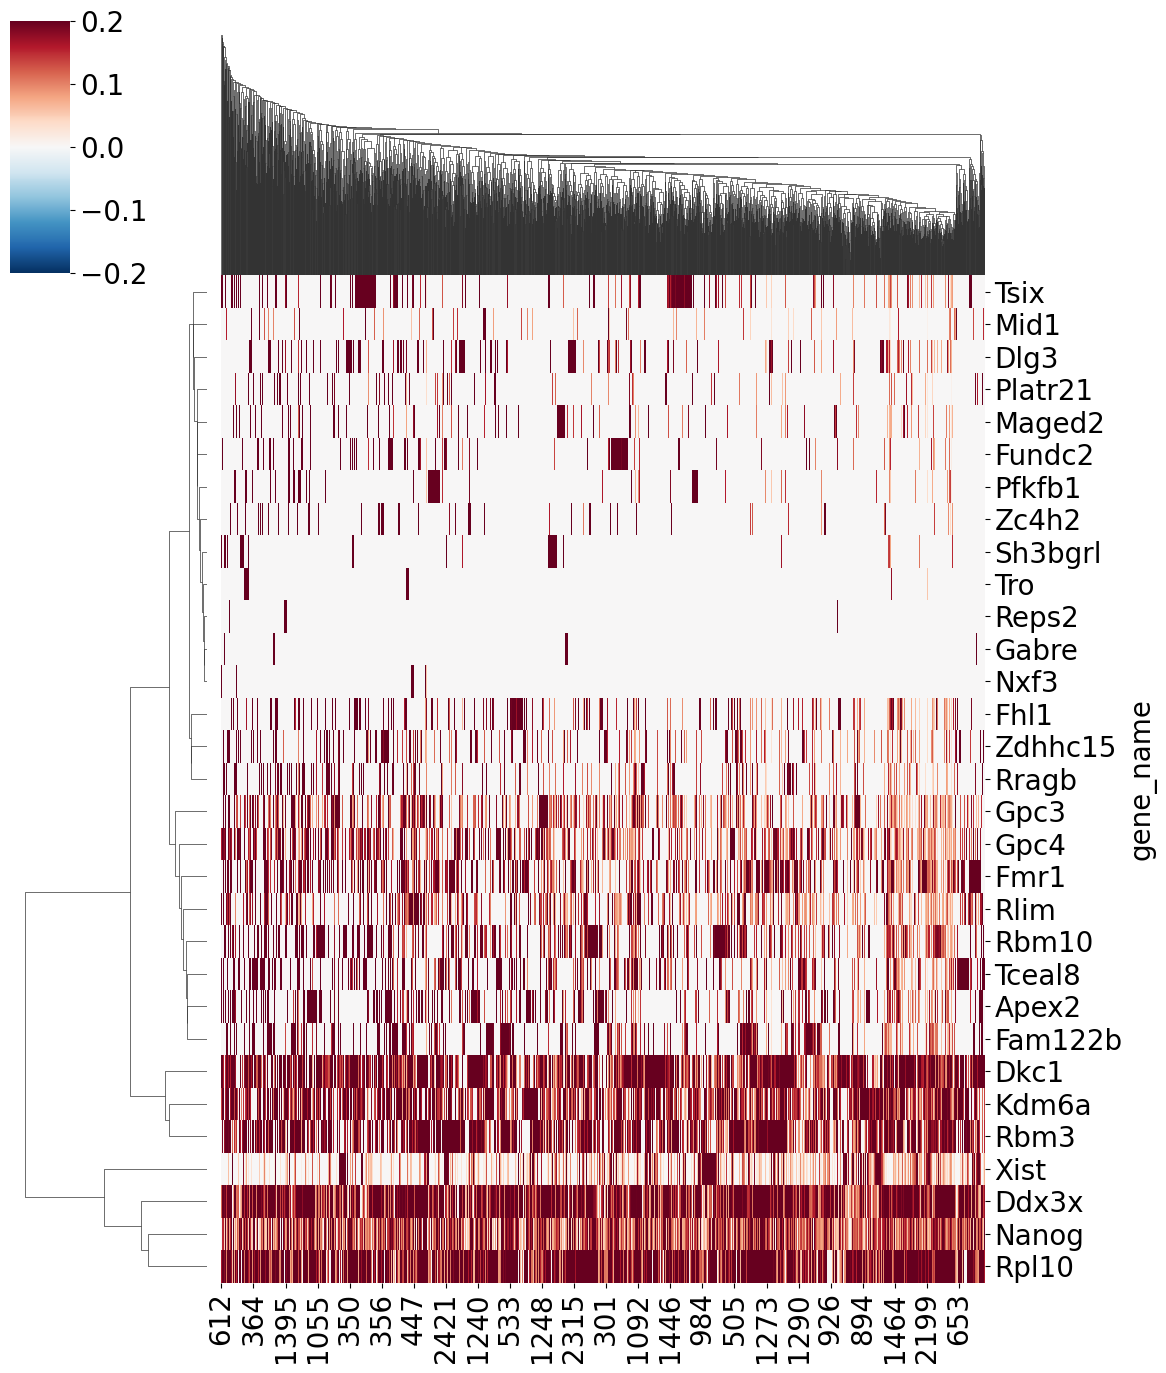

In [164]:
#filtered_data = data[data.obs['id'].str.endswith('[RTBC1]')].copy()
_xdata = adata.copy()
genes_to_keep = ['Xist','Nanog','Kdm6a','Dkc1','Rbm3','Rpl10','Mid1','Rbm10',
                 'Fmr1','Ddx3x','Platr21','Gabre','Pfkfb1','Tsix','Sh3bgrl','Apex2',
                 'Tro','Fhl1','Fam122b','Maged2','Zdhhc15','Reps2','Nxf3','Fundc2','Rragb',
                 'Gpc3','Dlg3','Tceal8','Zc4h2','Gpc4','Rlim']
gene_indices = [_xdata.var_names.get_loc(gene) for gene in genes_to_keep]


if scipy.sparse.issparse(_xdata.X):
    total_counts_per_cell = np.array(_xdata.X.sum(axis=1)).flatten()
else:
    total_counts_per_cell = _xdata.X.sum(axis=1)

total_counts_per_cell[total_counts_per_cell == 0] = np.nan


cpm_matrix = _xdata.X.copy()


# Step 2 and 3: Normalize counts to CPM

if scipy.sparse.issparse(cpm_matrix):
    # For sparse matrix, perform operation without densifying the whole matrix
    cpm_matrix = scipy.sparse.csr_matrix(cpm_matrix)
    cpm_matrix.data = cpm_matrix.data / np.repeat(total_counts_per_cell, np.diff(cpm_matrix.indptr)) * 1e6
else:
    # For dense matrix
    cpm_matrix = (cpm_matrix / total_counts_per_cell[:, None]) * 1e6

# Update xdata.X with the normalized CPM values
_xdata.X = cpm_matrix


# Subset the AnnData object to only include the selected genes
_xdata = _xdata[:, gene_indices]
non_zero_genes = np.array(_xdata.X.T.toarray().sum(axis=1)).flatten() >= 15

xist_gene_expression = _xdata[:, _xdata.var['gene_name'] == 'Xist'].X
if scipy.sparse.issparse(xist_gene_expression):
    xist_gene_expression = xist_gene_expression.toarray().flatten()
else:
    xist_gene_expression = xist_gene_expression.flatten()

# Step 2: Order the cells by "Xist" expression (from low to high)
ordered_cell_indices = np.argsort(xist_gene_expression)

xdata_ordered = _xdata[ordered_cell_indices, non_zero_genes] # non_zero_genes

_xdata = xdata_ordered

xist__expression = _xdata[:, 'Xist'].X  # Extracts the expression values of Xist across all barcodes/cells

# Identify the indices where Xist expression is not zero
#non_zero_xist_indices = xist__expression.nonzero()[0]

# Filter the AnnData object to keep only those barcodes/cells
#adata_filtered = _xdata[non_zero_xist_indices, :]
#xdata_ordered = adata_filtered

# TODO: Filter further!!
xdata_ordered1 = xdata_ordered[xdata_ordered.obs['id'].str.endswith('[RTBC1]')].copy()
xdata_ordered2 = xdata_ordered[xdata_ordered.obs['id'].str.endswith('[RTBC2]')].copy()
xdata_ordered3 = xdata_ordered[xdata_ordered.obs['id'].str.endswith('[RTBC3]')].copy()
xdata_ordered4 = xdata_ordered[xdata_ordered.obs['id'].str.endswith('[RTBC4]')].copy()
xdata_ordered5 = xdata_ordered[xdata_ordered.obs['id'].str.endswith('[RTBC5]')].copy()
xdata_ordered6 = xdata_ordered[xdata_ordered.obs['id'].str.endswith('[RTBC6]')].copy()

adata_combined = xdata_ordered1.copy()
adata_combined = anndata.concat([adata_combined, xdata_ordered2], axis=0, join='outer', merge='same')
adata_combined = anndata.concat([adata_combined, xdata_ordered3], axis=0, join='outer', merge='same')
adata_combined = anndata.concat([adata_combined, xdata_ordered4], axis=0, join='outer', merge='same')
adata_combined = anndata.concat([adata_combined, xdata_ordered5], axis=0, join='outer', merge='same')
adata_combined = anndata.concat([adata_combined, xdata_ordered6], axis=0, join='outer', merge='same')

xdata_ordered = adata_combined.copy()

#xdata_ordered = xdata_ordered1
# 

# Convert the ordered expression data to a dense DataFrame for plotting
if scipy.sparse.issparse(xdata_ordered.X):
    expr_matrix_dense = xdata_ordered.X.toarray()
else:
    expr_matrix_dense = xdata_ordered.X

genes = xdata_ordered.var['gene_name']
cells = np.array(range(xdata_ordered.n_obs))

#expr_matrix_dense = np.log2(expr_matrix_dense + 1)

z_scores_matrix = zscore(expr_matrix_dense, axis=1)

# Some genes might have constant expression across all cells leading to NaN values in z-scores
# You can handle NaN values as needed, for example, by replacing them with 0
z_scores_matrix = np.nan_to_num(z_scores_matrix)

# Creating a DataFrame with gene names as rows and cells as columns
df_expr = pd.DataFrame(z_scores_matrix.T, index=genes, columns=cells)
df_expr2 = pd.DataFrame(expr_matrix_dense.T, index=genes, columns=cells)


gene_distances = pdist(df_expr, metric='euclidean')

# Perform hierarchical clustering using the Ward method
gene_linkage = linkage(gene_distances, method='ward')

print(df_expr.shape)

max_abs_value = np.abs(df_expr.values).max()


# Step 4: Plot the heatmap
plt.figure(figsize=(12, 14))
#sns.heatmap(df_expr, cmap='viridis', yticklabels=True)
g = sns.clustermap(df_expr2, cmap='RdBu_r', cbar=True,
                   center=0, vmin=-0.2, vmax=0.2, standard_scale=0,
                   row_linkage=gene_linkage, col_cluster=True, figsize=(12, 14), yticklabels=True)
#plt.title('Gene Expression Heatmap Ordered by Xist Expression')
#plt.xlabel('Cells Ordered by Xist Expression')
#plt.ylabel('Genes')
plt.show()


# Some scanpy clustering analysis on the total AnnData

In [196]:
_data = adata.copy()
n_top_genes = 250
n_neighbors = 17
state = 42
num_PCA = 50
n_bins = 20
min_genes=200
min_cells=25

In [197]:
random.seed(state)
sc.pp.filter_cells(_data, min_genes=min_genes) # 5
sc.pp.filter_genes(_data, min_cells=min_cells) # 5
flavor="seurat"
_data.layers["raw"] = _data.X
scale_num = 1000000
_data.layers["norm"] = normalize(_data.X, norm="l1", axis=1)*scale_num
_data.layers["log1p"] = np.log1p(_data.layers["norm"])
_data.uns = OrderedDict([("log1p", {"base":None})])
_data.X = _data.layers["log1p"]
sc.pp.highly_variable_genes(_data, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = _data.var.highly_variable.values
mat = _data.layers["log1p"].todense()
_data.layers["scale"] = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
_data.X = _data.layers["scale"]
del mat

In [198]:
X = _data.X[:,hvg_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
_data.obsm["X_pca"] = tsvd.fit_transform(X)

In [199]:
sc.pp.neighbors(_data, n_neighbors=n_neighbors, n_pcs=46, random_state=state)

In [200]:
sc.tl.leiden(_data, random_state=state)

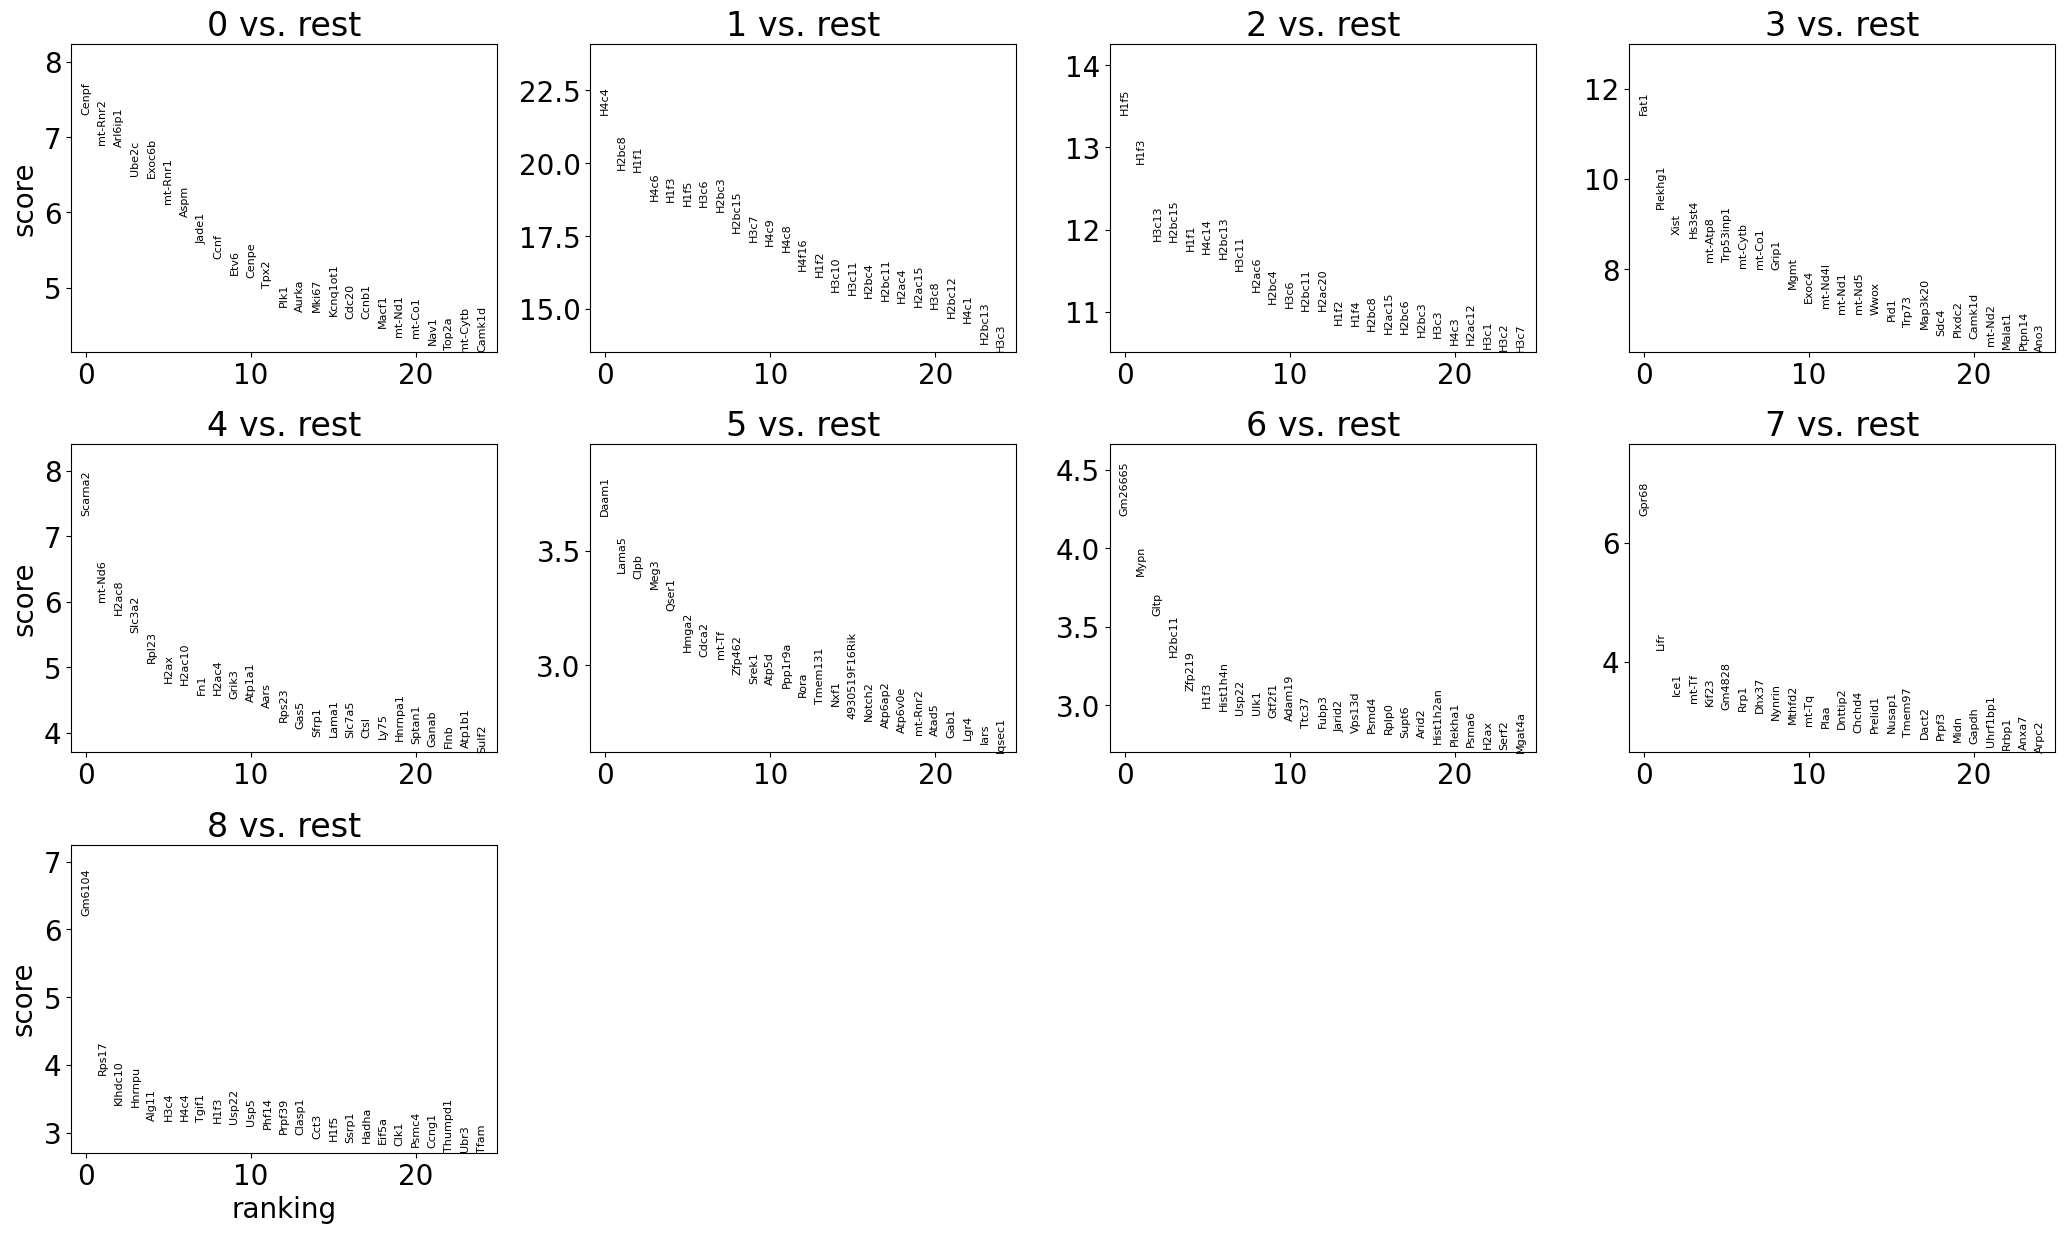

In [201]:
sc.tl.rank_genes_groups(_data, 'leiden', method='wilcoxon', corr_method="bonferroni")
sc.pl.rank_genes_groups(_data, n_genes=25, sharey=False)

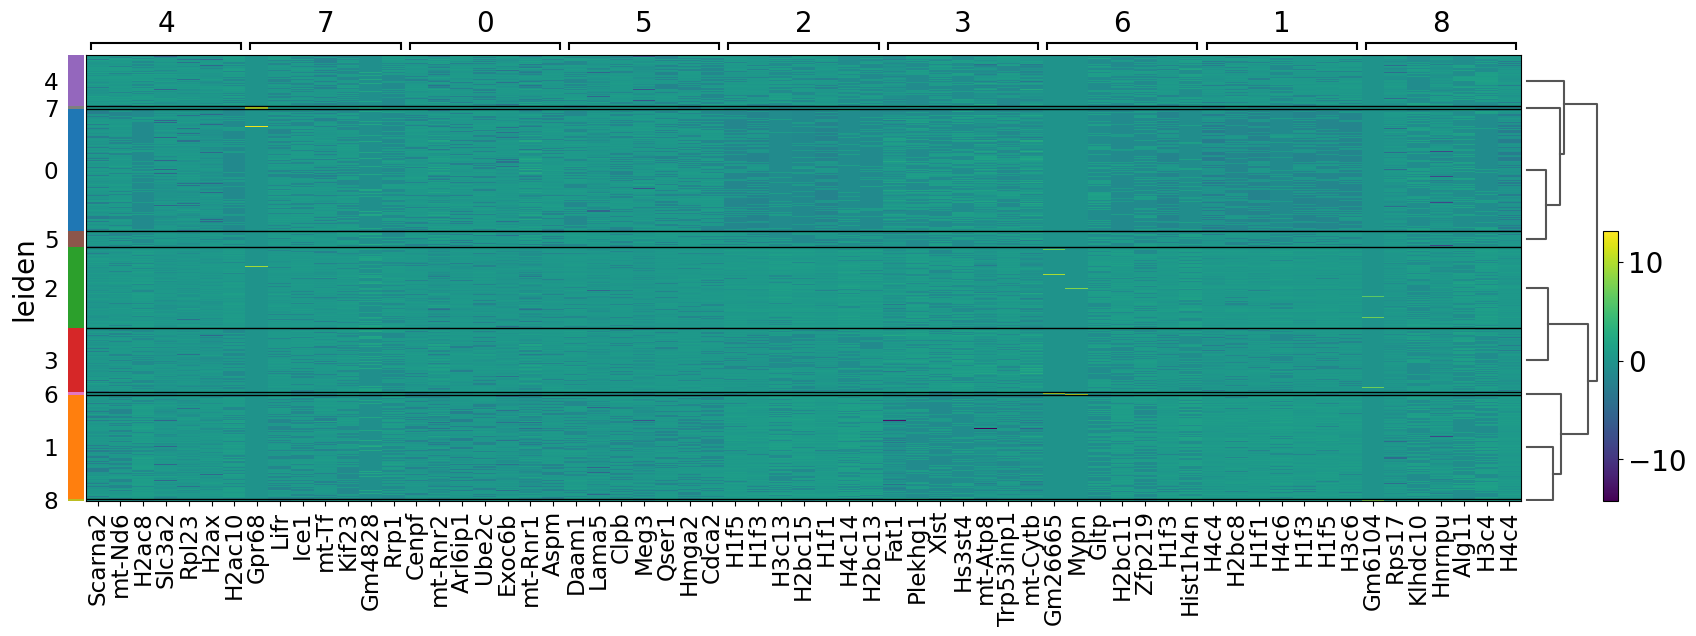

In [202]:
sc.pl.rank_genes_groups_heatmap(_data, n_genes=7, groupby='leiden', key='rank_genes_groups', 
                                show_gene_labels=True, cmap='viridis', figsize=(20, 6), gene_symbols="gene_name")

## Form an Xist-expressing and a non-Xist-expressing cluster

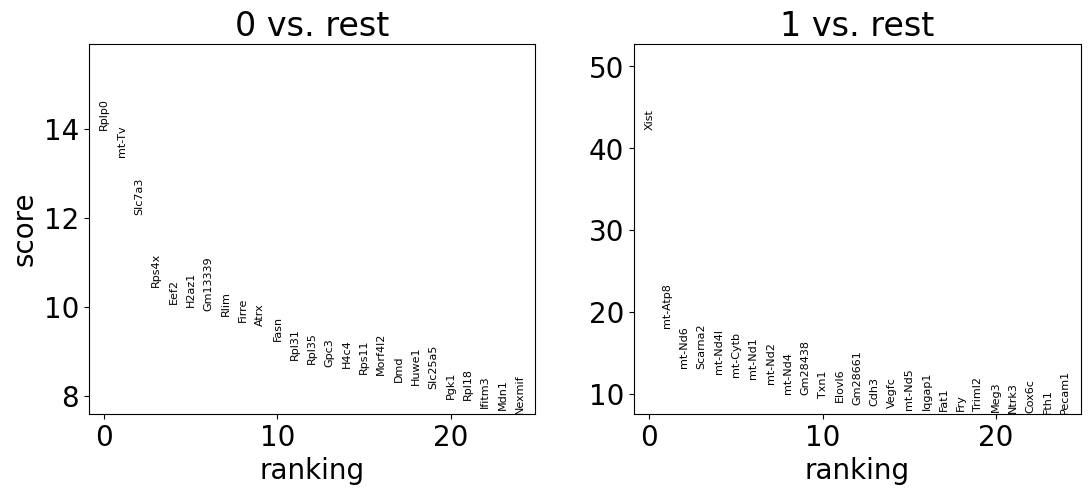

In [203]:
Xist_expression = None
if scipy.sparse.issparse(_data.X):
    Xist_expression = np.array(_data[:, _data.var_names == 'Xist'].X.toarray()).flatten()
else:
    Xist_expression = np.array(_data[:, _data.var_names == 'Xist'].X).flatten()

# Create the binary grouping based on 'Xist' expression, initially as integer
_data.obs['Xist_group'] = (Xist_expression > 0).astype(int)

# Now, convert the 'Xist_group' column to 'category' dtype
_data.obs['Xist_group'] = _data.obs['Xist_group'].astype('category')

# Proceed with differential expression analysis
sc.tl.rank_genes_groups(_data, 'Xist_group', method='wilcoxon', corr_method="bonferroni")

# Plot the differential expression results
sc.pl.rank_genes_groups(_data, n_genes=25, sharey=False)

# Get a table of the mean counts-per-million (CPM) for each gene across all cells for the total AnnData

In [205]:
cpm = adata.X / adata.X.sum(axis=1) * 1e6
cpm_df = pd.DataFrame(cpm, columns=adata.var['gene_name'])
mean_cpm = cpm_df.mean(axis=0)
mean_cpm

gene_name
4933401J01Rik     0.000000
Gm26206           0.000000
Xkr4              2.393476
Gm18956           0.000000
Gm37180           0.000000
                    ...   
CAAA01205117.1    0.000000
CAAA01098150.1    0.000000
CAAA01064564.1    0.000000
Vmn2r122          0.000000
CAAA01147332.1    1.098645
Length: 55487, dtype: float64